In [2]:
!pip install plotly
!pip install matplotlib_venn

In [3]:
from google.cloud import bigquery
import pandas as pd
import os
import datetime
from datetime import date, timedelta, datetime
from google.cloud import storage
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from plotly.subplots import make_subplots
from matplotlib_venn import venn3


# Conversion: click buy button

In [4]:
client = bigquery.Client()

In [5]:
client

### Frequency Range Metrics

In [6]:
query = '''
SELECT * 
FROM `rb-hygiene-markets-global-prod.adh_results_apac.rc_groupg19_freq_imp_conv_dv360youtube_1_20210712_20210822_2`
'''
df = client.query(query)
df= df.to_dataframe()
df.to_csv('df.csv', index=False)

#df = pd.read_csv("df.csv")
df

partner_id  advertiser_id  campaign_id  frequency    reach  \
0    599149418      603701472      6822204          0    10005   
1    599149418      603701472      6822204          1  3368144   
2    599149418      603701472      6822204          2  1181520   
3    599149418      603701472      6822204          3   726115   
4    599149418      603701472      6822204          4   487921   
5    599149418      603701472      6822204          5   361392   
6    599149418      603701472      6822204          6   281603   
7    599149418      603701472      6822204          7   218583   
8    599149418      603701472      6822204          8   172967   
9    599149418      603701472      6822204          9   140452   
10   599149418      603701472      6822204         10   111578   
11   599149418      603701472      6822204         11    89144   
12   599149418      603701472      6822204         12    72191   
13   599149418      603701472      6822204         13    57096   
14   599149418      603701472      6822204         14    44902   
15   599149418      603701472      6822204         15    36380   
16   599149418      603701472      6822204         16    28852   
17   599149418      603701472      6822204         17    22711   
18   599149418      603701472      6822204         18    17968   
19   599149418      603701472      6822204         19    44454   

    total_impressions  total_clicks  total_conversions  \
0                   0         15987                  0   
1             3368144       1325647                 37   
2             2363040       1240007                 33   
3             2178345       1284213                 40   
4             1951684       1180672                 23   
5             1806960       1102538                 29   
6             1689618       1015030                 16   
7             1530081        920588                 19   
8             1383736        834060                 24   
9             1264068        762550                 12   
10            1115780        675753                 17   
11             980584        595134                 25   
12             866292        527583                 10   
13             742248        452258                  6   
14             628628        383852                  5   
15             545700        332224                  5   
16             461632        282327                  5   
17             386087        236497                 12   
18             323424        199482                  1   
19            3359997       1919311                 38   

    unique_user_conversions2  total_imp_know  ...  perc_imp_know  \
0                          0               0  ...            NaN   
1                         26          838670  ...         24.900   
2                         28          771775  ...         32.660   
3                         33          781578  ...         35.879   
4                         19          777607  ...         39.843   
5                         24          767702  ...         42.486   
6                         15          754770  ...         44.671   
7                         13          714905  ...         46.723   
8                         15          661404  ...         47.798   
9                         11          612876  ...         48.484   
10                        12          543164  ...         48.680   
11                        12          476386  ...         48.582   
12                         8          419546  ...         48.430   
13                         4          355335  ...         47.873   
14                         4          297287  ...         47.291   
15                         4          253961  ...         46.539   
16                         4          211250  ...         45.762   
17                         5          173991  ...         45.065   
18                         1          143887  ...         44.489   
19                        15         1

In [7]:
df_an = df[['frequency','reach', 'total_impressions','total_clicks','total_conversions','dv360_youtube_media_cost']]
df_an = df_an[df_an.frequency > 0]
summary = pd.DataFrame(df_an.iloc[:,1::].sum(), columns=['Sum']).transpose()
summary

reach  total_impressions  total_clicks  total_conversions  \
Sum  7463973.0         26946048.0    15269726.0              357.0   

     dv360_youtube_media_cost  
Sum                  44451.68

In [8]:
# create a list of our conditions
conditions = [
    (df_an['frequency'] == 1),
    (df_an['frequency'] > 1)  & (df_an['frequency'] <= 6),
    (df_an['frequency'] > 6)  & (df_an['frequency'] <= 12),
    (df_an['frequency'] > 12) & (df_an['frequency'] <= 18),
    (df_an['frequency'] > 18)
    ]

# create a list of the values we want to assign for each condition
values = ['1', '2-6', '7-12', '13-18', '19-30']

# create a new column and use np.select to assign values to it using our lists as arguments
df_an['frequency_range'] = np.select(conditions, values)

# display updated DataFrame
df_an = df_an[['frequency_range','reach', 'total_impressions','total_clicks','total_conversions','dv360_youtube_media_cost']].groupby(by='frequency_range').sum()
df_an = round(df_an/df_an.sum()*100,1)
df_an

reach  total_impressions  total_clicks  total_conversions  \
frequency_range                                                              
1                 45.1               12.5           8.7               10.4   
13-18              2.8               11.5          12.4                9.5   
19-30              0.6               12.5          12.6               10.6   
2-6               40.7               37.1          38.1               39.5   
7-12              10.8               26.5          28.3               30.0   

                 dv360_youtube_media_cost  
frequency_range                            
1                                    10.9  
13-18                                10.8  
19-30                                12.2  
2-6                                  40.3  
7-12                                 25.8

In [9]:
df_an.sum()

reach                       100.0
total_impressions           100.1
total_clicks                100.1
total_conversions           100.0
dv360_youtube_media_cost    100.0
dtype: float64

Conversion Rate and CPA

In [13]:
df_an = df[['frequency','reach', 'total_impressions','total_clicks','total_conversions', 'unique_user_conversions2', 'dv360_youtube_media_cost']]
df_an = df_an[df_an.frequency > 0]
summary = pd.DataFrame(df_an.iloc[:,1::].sum(), columns=['Sum']).transpose()
summary

reach  total_impressions  total_clicks  total_conversions  \
Sum  7463973.0         26946048.0    15269726.0              357.0   

     unique_user_conversions2  dv360_youtube_media_cost  
Sum                     253.0                  44451.68

In [14]:
# create a list of our conditions
conditions = [
    (df_an['frequency'] == 1),
    (df_an['frequency'] > 1)  & (df_an['frequency'] <= 6),
    (df_an['frequency'] > 6)  & (df_an['frequency'] <= 12),
    (df_an['frequency'] > 12) & (df_an['frequency'] <= 18),
    (df_an['frequency'] > 18)
    ]

# create a list of the values we want to assign for each condition
values = ['1', '2-6', '7-12', '13-18', '19-30']

# create a new column and use np.select to assign values to it using our lists as arguments
df_an['frequency_range'] = np.select(conditions, values)

# display updated DataFrame
df_an = df_an[['frequency_range','reach', 'total_impressions','total_clicks','total_conversions', 'unique_user_conversions2','dv360_youtube_media_cost']].groupby(by='frequency_range').sum()
#df_an = round(df_an/df_an.sum()*100,1)
df_an

reach  total_impressions  total_clicks  total_conversions  \
frequency_range                                                                
1                3368144            3368144       1325647                 37   
13-18             207909            3087719       1886640                 34   
19-30              44454            3359997       1919311                 38   
2-6              3038551            9989647       5822460                141   
7-12              804915            7140541       4315668                107   

                 unique_user_conversions2  dv360_youtube_media_cost  
frequency_range                                                      
1                                      26                   4828.12  
13-18                                  22                   4816.69  
19-30                                  15                   5435.56  
2-6                                   119                  17903.41  
7-12                                   71                  11467.90

In [15]:
df_an['cvr'] = df_an.total_conversions/ df_an.total_impressions*100
df_an['CPA'] = df_an.dv360_youtube_media_cost/ df_an.total_conversions
df_an['cvr_unique_conv'] = df_an.unique_user_conversions2/ df_an.total_impressions*100
df_an['CPA_unique_conv'] = df_an.dv360_youtube_media_cost/ df_an.unique_user_conversions2
df_an

reach  total_impressions  total_clicks  total_conversions  \
frequency_range                                                                
1                3368144            3368144       1325647                 37   
13-18             207909            3087719       1886640                 34   
19-30              44454            3359997       1919311                 38   
2-6              3038551            9989647       5822460                141   
7-12              804915            7140541       4315668                107   

                 unique_user_conversions2  dv360_youtube_media_cost       cvr  \
frequency_range                                                                 
1                                      26                   4828.12  0.001099   
13-18                                  22                   4816.69  0.001101   
19-30                                  15                   5435.56  0.001131   
2-6                                   119                  17903.41  0.001411   
7-12                                   71                  11467.90  0.001498   

                        CPA  cvr_unique_conv  CPA_unique_conv  
frequency_range                                                
1                130.489730         0.000772       185.696923  
13-18            141.667353         0.000713       218.940455  
19-30            143.041053         0.000446       362.370667  
2-6              126.974539         0.001191       150.448824  
7-12             107.176636         0.000994       161.519718

### Plot Analysis

In [76]:
query = '''
SELECT * 
FROM `rb-hygiene-markets-global-prod.adh_results_apac.rc_freq_imp_conv_dv360youtube_2_20210712_20210822_2`
'''
df = client.query(query)
df= df.to_dataframe()
df.to_csv('df.csv', index=False)

#df = pd.read_csv("df.csv")


In [77]:
df.head(30)

partner_id  advertiser_id  campaign_id  frequency    reach  \
0           NaN            NaN          NaN        NaN      509   
1   599149418.0    603701472.0    6822204.0        0.0    10020   
2   599149418.0    603701472.0    6822204.0        1.0  3377512   
3   599149418.0    603701472.0    6822204.0        2.0  1183311   
4   599149418.0    603701472.0    6822204.0        3.0   728105   
5   599149418.0    603701472.0    6822204.0        4.0   489773   
6   599149418.0    603701472.0    6822204.0        5.0   363044   
7   599149418.0    603701472.0    6822204.0        6.0   283181   
8   599149418.0    603701472.0    6822204.0        7.0   219863   
9   599149418.0    603701472.0    6822204.0        8.0   173978   
10  599149418.0    603701472.0    6822204.0        9.0   141394   
11  599149418.0    603701472.0    6822204.0       10.0   112448   
12  599149418.0    603701472.0    6822204.0       11.0    89836   
13  599149418.0    603701472.0    6822204.0       12.0    72818   
14  599149418.0    603701472.0    6822204.0       13.0    57597   
15  599149418.0    603701472.0    6822204.0       14.0    45248   
16  599149418.0    603701472.0    6822204.0       15.0    36695   
17  599149418.0    603701472.0    6822204.0       16.0    29181   
18  599149418.0    603701472.0    6822204.0       17.0    22915   
19  599149418.0    603701472.0    6822204.0       18.0    18154   
20  599149418.0    603701472.0    6822204.0       19.0    13728   
21  599149418.0    603701472.0    6822204.0       20.0    10267   
22  599149418.0    603701472.0    6822204.0       21.0     7575   
23  599149418.0    603701472.0    6822204.0       22.0     4911   
24  599149418.0    603701472.0    6822204.0       23.0     3207   
25  599149418.0    603701472.0    6822204.0       24.0     2123   
26  599149418.0    603701472.0    6822204.0       25.0     1364   
27  599149418.0    603701472.0    6822204.0       26.0      832   
28  599149418.0    603701472.0    6822204.0       27.0      474   
29  599149418.0    603701472.0    6822204.0       30.0      111   

    total_impressions  total_clicks  total_conversions  total_imp_know  \
0             2308555       1249903                  7          816242   
1                   0         16006                  0               0   
2             3377512       1326149                 34          837925   
3             2366622       1239732                 34          770798   
4             2184315       1285639                 40          780163   
5             1959092       1184740                 20          777392   
6             1815220       1106924                 30          768497   
7             1699086       1020161                 17          756112   
8             1539041        925852                 19          716577   
9             1391824        839193                 24          663526   
10            1272546        767770                 12          615084   
11            1124480        680861                 17          546220   
12             988196        599489                 14          479396   
13             873816        532273                 22          422362   
14             748761        456380                  5          358057   
15             633472        386609                  6          299357   
16             550425        335497                  5          255930   
17             466896        285556                  4          213506   
18             389555        238830                  4          175393   
19             326772        201515                 10          145350   
20             260832        163483                  1          113938   
21             205340        130843                  8           88272   
22             159075        102791                  3           67254   
23             108042         71342                  2           44722   
24              73761         50315                  1           29804   
25 

Percentage of imp excluded due privacy checks


In [86]:
round(df['total_impressions'][0]/df['total_impressions'].sum()*100,2)

8.57

In [8]:
df['dv360_youtube_media_cost'].sum()

44460.78

In [15]:
df = df[df.frequency > 0]
df['cumsum_reach'] = df['reach'].cumsum()
df['cumsum_imp'] = df['total_impressions'].cumsum()
df['cumsum_conv'] = df['total_conversions'].cumsum()
df['cumsum_cost'] = df['dv360_youtube_media_cost'].cumsum()
df['cumsum_imp_cost'] = df['dv360_imp_cost'].cumsum()
df['cumsum_click_cost'] = df['dv360_clicks_cost'].cumsum()
df

partner_id  advertiser_id  campaign_id  frequency    reach  \
2   599149418.0    603701472.0    6822204.0        1.0  3377512   
3   599149418.0    603701472.0    6822204.0        2.0  1183311   
4   599149418.0    603701472.0    6822204.0        3.0   728105   
5   599149418.0    603701472.0    6822204.0        4.0   489773   
6   599149418.0    603701472.0    6822204.0        5.0   363044   
7   599149418.0    603701472.0    6822204.0        6.0   283181   
8   599149418.0    603701472.0    6822204.0        7.0   219863   
9   599149418.0    603701472.0    6822204.0        8.0   173978   
10  599149418.0    603701472.0    6822204.0        9.0   141394   
11  599149418.0    603701472.0    6822204.0       10.0   112448   
12  599149418.0    603701472.0    6822204.0       11.0    89836   
13  599149418.0    603701472.0    6822204.0       12.0    72818   
14  599149418.0    603701472.0    6822204.0       13.0    57597   
15  599149418.0    603701472.0    6822204.0       14.0    45248   
16  599149418.0    603701472.0    6822204.0       15.0    36695   
17  599149418.0    603701472.0    6822204.0       16.0    29181   
18  599149418.0    603701472.0    6822204.0       17.0    22915   
19  599149418.0    603701472.0    6822204.0       18.0    18154   
20  599149418.0    603701472.0    6822204.0       19.0    13728   
21  599149418.0    603701472.0    6822204.0       20.0    10267   
22  599149418.0    603701472.0    6822204.0       21.0     7575   
23  599149418.0    603701472.0    6822204.0       22.0     4911   
24  599149418.0    603701472.0    6822204.0       23.0     3207   
25  599149418.0    603701472.0    6822204.0       24.0     2123   
26  599149418.0    603701472.0    6822204.0       25.0     1364   
27  599149418.0    603701472.0    6822204.0       26.0      832   
28  599149418.0    603701472.0    6822204.0       27.0      474   
29  599149418.0    603701472.0    6822204.0       30.0      111   

    total_impressions  total_clicks  total_conversions  total_imp_know  \
2             3377512       1326149                 34          837925   
3             2366622       1239732                 34          770798   
4             2184315       1285639                 40          780163   
5             1959092       1184740                 20          777392   
6             1815220       1106924                 30          768497   
7             1699086       1020161                 17          756112   
8             1539041        925852                 19          716577   
9             1391824        839193                 24          663526   
10            1272546        767770                 12          615084   
11            1124480        680861                 17          546220   
12             988196        599489                 14          479396   
13             873816        532273                 22          422362   
14             748761        456380                  5          358057   
15             633472        386609                  6          299357   
16             550425        335497                  5          255930   
17             466896        285556                  4          213506   
18             389555        238830                  4          175393   
19             326772        201515                 10          145350   
20             260832        163483                  1          113938   
21             205340        130843                  8           88272   
22             159075        102791                  3           67254   
23             108042         71342                  2           44722   
24              73761         50315                  1           29804   
25              50952         35522                  0           20098   
26              34100         24295                  1           13169   
27              21632         15924                 14            8262   
28              12798          9527                  0         

### Bar plot with count values

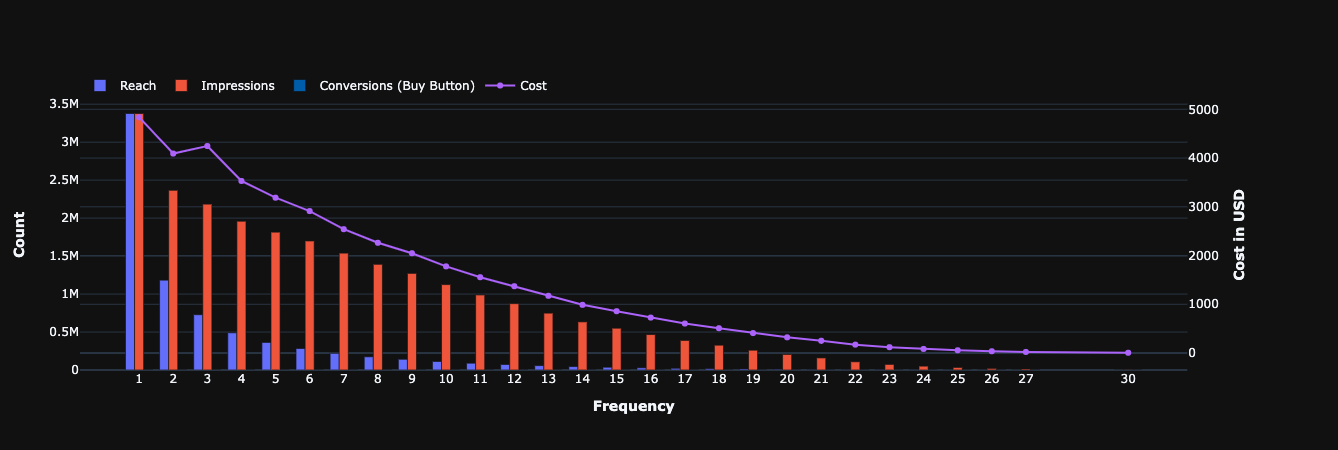

In [16]:
#fig = go.Figure()
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Bar(x=df.frequency,
                     y=df["reach"],
                     name="Reach"), secondary_y=False,)

fig.add_trace(go.Bar(x=df.frequency,
                     y=df["total_impressions"],
                     name="Impressions"), secondary_y=False,)

fig.add_trace(go.Bar(x=df.frequency,
                     y=df["total_conversions"],
                     name="Conversions (Buy Button)", marker_color='#005daa'), secondary_y=False,)

fig.add_trace(go.Scatter(x=df.frequency, y=df.dv360_youtube_media_cost,
                    mode='lines+markers',
                    name='Cost'), secondary_y=True,)


fig.update_layout(
    #title='<b>Reach & Impressions & Conversions - Buy </b>',
    template="plotly_dark",
    xaxis = dict(
        tickmode = 'array',
        tickvals = df["frequency"],
        ticktext = df["frequency"]),
    xaxis_title="<b>Frequency</b>",
)

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1,
    xanchor="left",
    x=0
))

# Set y-axes titles
fig.update_yaxes(title_text="<b>Count</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>Cost in USD</b>", secondary_y=True)

### Bar plot with cumulative values

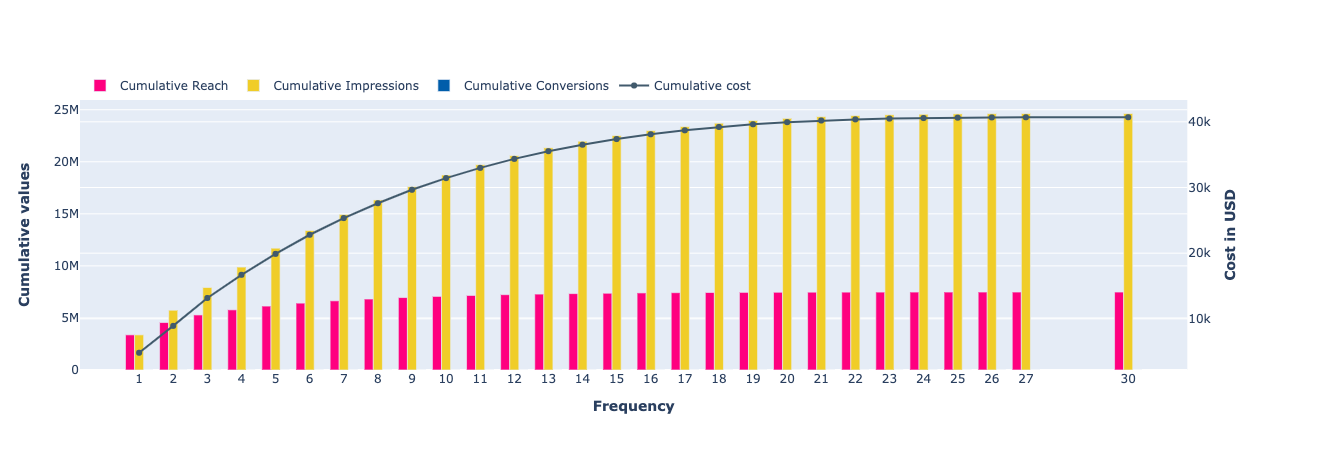

In [17]:
#fig = go.Figure()
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Bar(x=df.frequency,
                     y=df["cumsum_reach"],
                     name="Cumulative Reach", marker_color='#ff007f'), secondary_y=False,)

fig.add_trace(go.Bar(x=df.frequency,
                     y=df["cumsum_imp"],
                     name="Cumulative Impressions", marker_color='#f0cd28'), secondary_y=False,)

#I don't add this trace because it is so small that it only appears in the legends

fig.add_trace(go.Bar(x=df.frequency,
                     y=df["cumsum_conv"],
                     name="Cumulative Conversions", marker_color='#005daa'), secondary_y=False,)

fig.add_trace(go.Scatter(x=df.frequency, y=df.cumsum_cost,
                    mode='lines+markers',
                    name='Cumulative cost', marker_color='#415a6c'), secondary_y=True,)


fig.update_layout(
    #title='<b>Bar plot with cumulative values</b>',
    #template="plotly_dark",
    xaxis = dict(
        tickmode = 'array',
        tickvals = df["frequency"],
        ticktext = df["frequency"]),
    xaxis_title="<b>Frequency</b>",
)

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1,
    xanchor="left",
    x=0
))

# Set y-axes titles
fig.update_yaxes(title_text="<b>Cumulative values</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>Cost in USD</b>", secondary_y=True)

### Bar plot with percentage count values

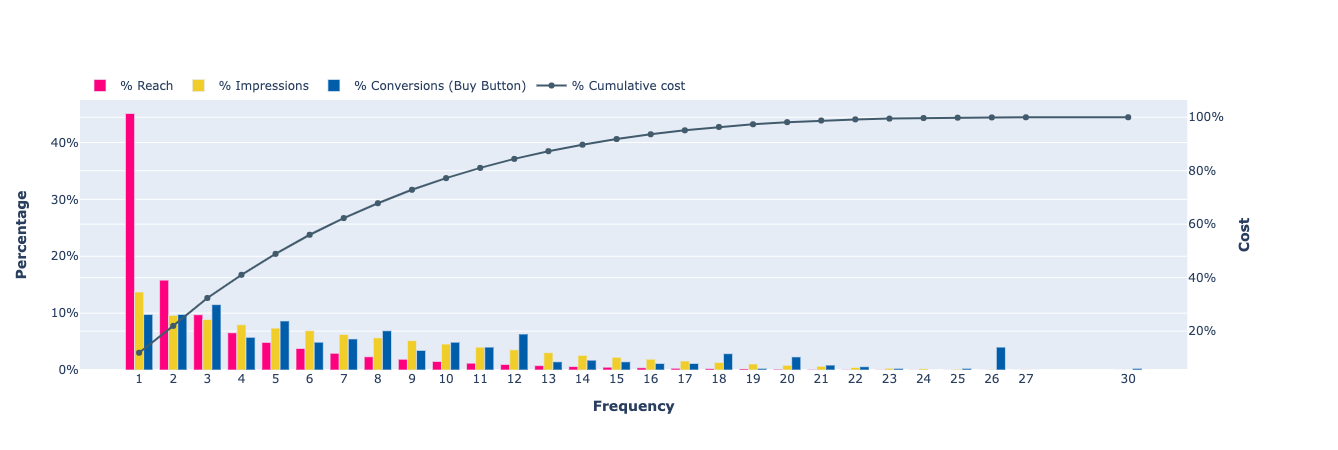

In [18]:
#fig = go.Figure()
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Bar(x=df.frequency,
                     y=df["reach"]/df["cumsum_reach"].max()*100,
                     name="% Reach", marker_color='#ff007f'), 
                     secondary_y=False)

fig.add_trace(go.Bar(x=df.frequency,
                     y=df["total_impressions"]/df["cumsum_imp"].max()*100,
                     name="% Impressions", marker_color='#f0cd28'),
                     secondary_y=False)

fig.add_trace(go.Bar(x=df.frequency,
                     y=df["total_conversions"]/df["cumsum_conv"].max()*100,
                     name="% Conversions (Buy Button)", marker_color='#005daa'),
                     secondary_y=False,)

fig.add_trace(go.Scatter(x=df.frequency, 
                         y=df.cumsum_cost/df.cumsum_cost.max()*100,
                         mode='lines+markers',
                         name='% Cumulative cost', marker_color='#415a6c'),
                         secondary_y=True,)


fig.update_layout(
    #title='<b>Bar plot with percentage count values</b>',
    #template="plotly_dark",
    xaxis = dict(
        tickmode = 'array',
        tickvals = df["frequency"],
        ticktext = df["frequency"]),
    xaxis_title="<b>Frequency</b>",
)


fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1,
    xanchor="left",
    x=0
))

# Set y-axes titles
fig.update_yaxes(title_text="<b>Percentage</b>", ticksuffix = "%", secondary_y=False)
fig.update_yaxes(title_text="<b>Cost</b>", ticksuffix = "%", secondary_y=True)

### Bar plot with cumulative percentages

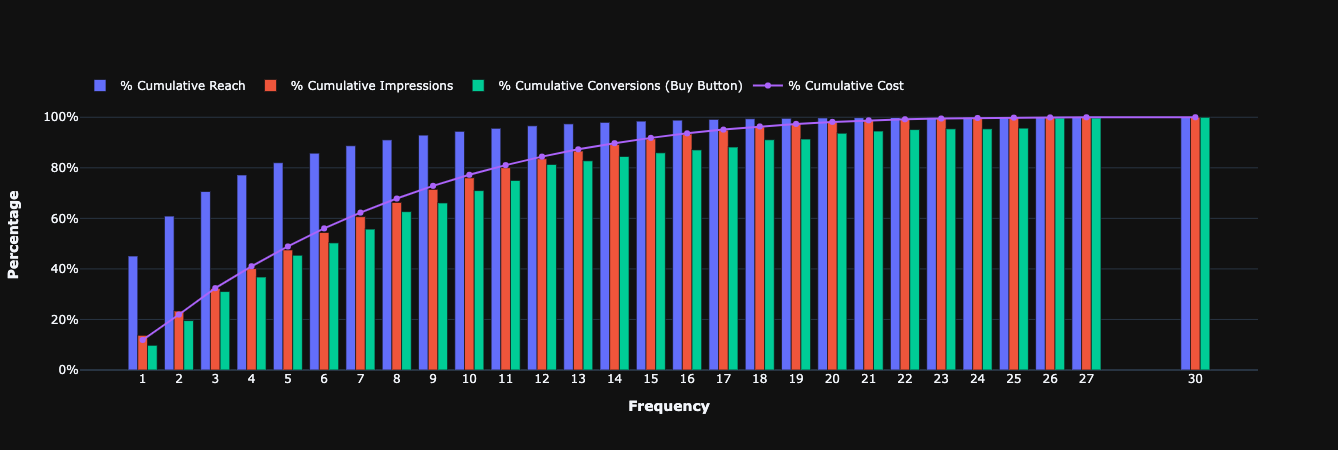

In [19]:
fig = go.Figure()


fig.add_trace(go.Bar(x=df.frequency,
                     y=df["cumsum_reach"]/df["cumsum_reach"].max()*100,
                     name="% Cumulative Reach"))

fig.add_trace(go.Bar(x=df.frequency,
                     y=df["cumsum_imp"]/df["cumsum_imp"].max()*100,
                     name="% Cumulative Impressions"))

fig.add_trace(go.Bar(x=df.frequency,
                     y=df["cumsum_conv"]/df["cumsum_conv"].max()*100,
                     name="% Cumulative Conversions (Buy Button)"))

fig.add_trace(go.Scatter(x=df.frequency, 
                         y=df.cumsum_cost/df.cumsum_cost.max()*100,
                         mode='lines+markers',
                         name='% Cumulative Cost'))


fig.update_layout(
    #title='<b>Bar plot with percentage values</b>',
    template="plotly_dark",
    xaxis = dict(
        tickmode = 'array',
        tickvals = df["frequency"],
        ticktext = df["frequency"]),
    xaxis_title="<b>Frequency</b>",
)

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1,
    xanchor="left",
    x=0
))

# Set y-axes titles
fig.update_yaxes(title_text="<b>Percentage</b>", ticksuffix = "%")


### Funnel impressions

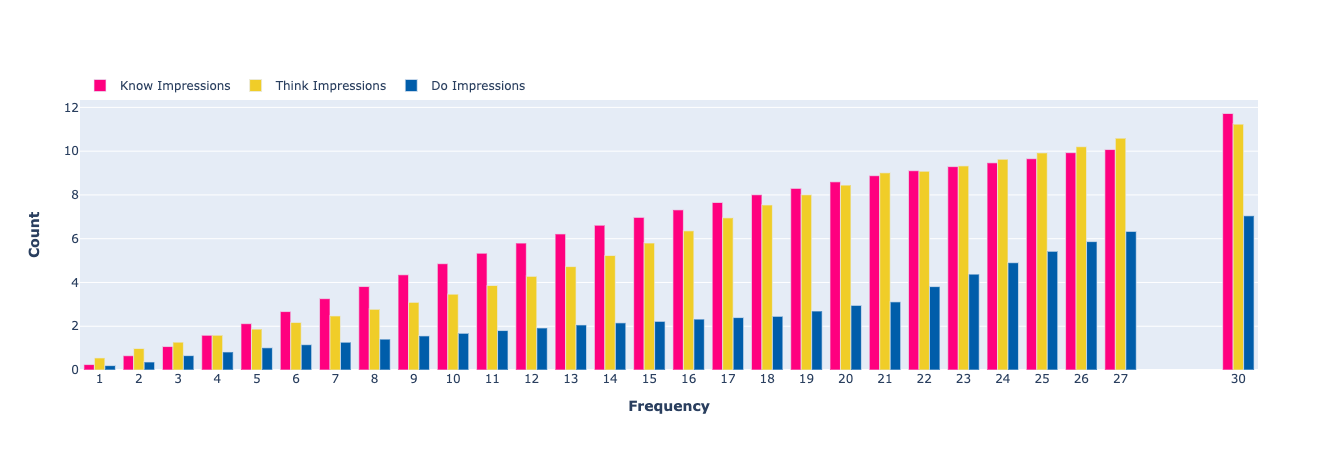

In [20]:
fig = go.Figure()

fig.add_trace(go.Bar(x=df.frequency,
                     y=df.total_imp_know/df.total_impressions*df.frequency,
                     name="Know Impressions", marker_color='#ff007f'))

fig.add_trace(go.Bar(x=df.frequency,
                     y=df.total_imp_think/df.total_impressions*df.frequency,
                     name="Think Impressions", marker_color='#f0cd28'))

fig.add_trace(go.Bar(x=df.frequency,
                     y=df.total_imp_do/df.total_impressions*df.frequency,
                     name="Do Impressions", marker_color='#005daa'))


fig.update_layout(
    #title='<b>Reach & Impressions & Conversions - Buy </b>',
    #template="plotly_dark",
    xaxis = dict(
        tickmode = 'array',
        tickvals = df["frequency"],
        ticktext = df["frequency"]),
    xaxis_title="<b>Frequency</b>",
)

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1,
    xanchor="left",
    x=0
))

# Set y-axes titles
fig.update_yaxes(title_text="<b>Count</b>")

In [21]:
aux = df.loc[(df.frequency>=7) & (df.frequency<=16)][['frequency', 'total_impressions', 'total_imp_know', 'total_imp_think', 'total_imp_do']]
aux['know_count'] =aux.total_imp_know/aux.total_impressions
aux['think_count'] =aux.total_imp_think/aux.total_impressions
aux['do_count'] =aux.total_imp_do/aux.total_impressions
aux

frequency  total_impressions  total_imp_know  total_imp_think  \
8         7.0            1539041          716577           543256   
9         8.0            1391824          663526           482807   
10        9.0            1272546          615084           437231   
11       10.0            1124480          546220           389606   
12       11.0             988196          479396           346839   
13       12.0             873816          422362           311647   
14       13.0             748761          358057           272120   
15       14.0             633472          299357           236673   
16       15.0             550425          255930           212918   
17       16.0             466896          213506           185526   

    total_imp_do  know_count  think_count  do_count  
8         279208    0.465600     0.352983  0.181417  
9         245491    0.476731     0.346888  0.176381  
10        220231    0.483349     0.343588  0.173063  
11        188654    0.485753     0.346477  0.167770  
12        161961    0.485122     0.350982  0.163896  
13        139807    0.483353     0.356651  0.159996  
14        118584    0.478199     0.363427  0.158374  
15         97442    0.472565     0.373612  0.153822  
16         81577    0.464968     0.386825  0.148207  
17         67864    0.457288     0.397360  0.145351

## Cost plots

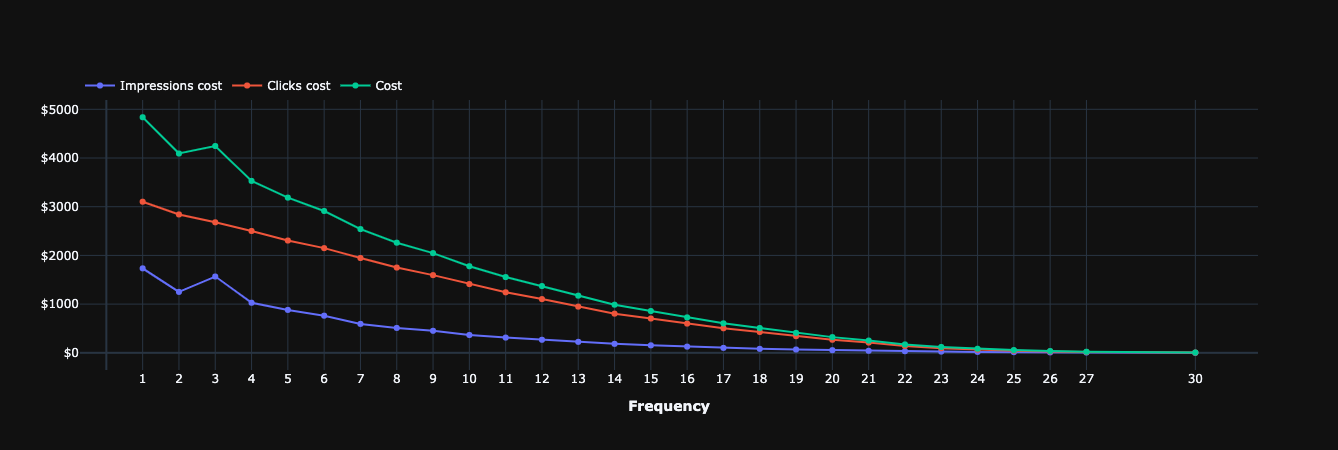

In [22]:
costs = df[['frequency', 'dv360_youtube_media_cost','dv360_imp_cost', 'dv360_clicks_cost', 'cumsum_cost', 'cumsum_imp_cost', 'cumsum_click_cost']]

fig = go.Figure()

fig.add_trace(go.Scatter(x=costs.frequency, 
                         y=costs.dv360_imp_cost,
                         mode='lines+markers',
                         name='Impressions cost'))

fig.add_trace(go.Scatter(x=costs.frequency, 
                         y=costs.dv360_clicks_cost,
                         mode='lines+markers',
                         name='Clicks cost'))

fig.add_trace(go.Scatter(x=costs.frequency, 
                         y=costs.dv360_youtube_media_cost,
                         mode='lines+markers',
                         name='Cost'))

fig.update_layout(
    #title='<b>Total cost in USD</b>',
    template="plotly_dark",
    xaxis = dict(
        tickmode = 'array',
        tickvals = df["frequency"],
        ticktext = df["frequency"]),
    xaxis_title="<b>Frequency</b>",
    yaxis = dict(tickprefix = "$")
)

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1,
    xanchor="left",
    x=0
))

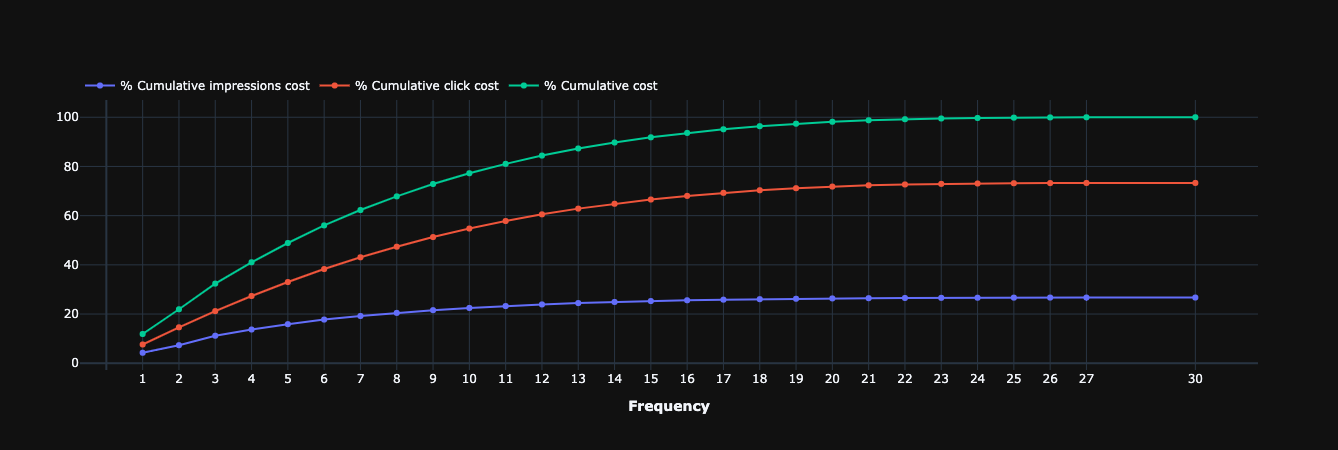

In [23]:
costs = df[['frequency', 'dv360_youtube_media_cost','dv360_imp_cost', 'dv360_clicks_cost', 'cumsum_cost', 'cumsum_imp_cost', 'cumsum_click_cost']]
fig = go.Figure()


fig.add_trace(go.Scatter(x=costs.frequency, 
                         y=costs.cumsum_imp_cost/costs.cumsum_cost.max()*100,
                         mode='lines+markers',
                         name='% Cumulative impressions cost'))

fig.add_trace(go.Scatter(x=costs.frequency, 
                         y=costs.cumsum_click_cost/costs.cumsum_cost.max()*100,
                         mode='lines+markers',
                         name='% Cumulative click cost'))

fig.add_trace(go.Scatter(x=costs.frequency, 
                         y=costs.cumsum_cost/costs.cumsum_cost.max()*100,
                         mode='lines+markers',
                         name='% Cumulative cost'))

fig.update_layout(
    #title='<b>Cumulative cost in %</b>',
    template="plotly_dark",
    xaxis = dict(
        tickmode = 'array',
        tickvals = df["frequency"],
        ticktext = df["frequency"]),
    xaxis_title="<b>Frequency</b>",
)

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1,
    xanchor="left",
    x=0
))


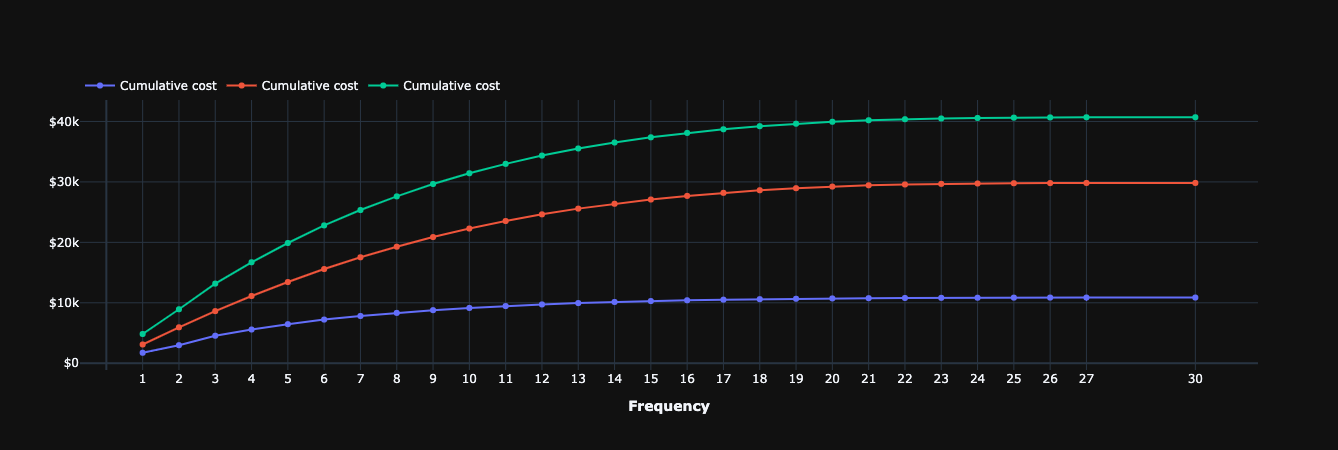

In [24]:
costs = df[['frequency', 'dv360_youtube_media_cost','dv360_imp_cost', 'dv360_clicks_cost', 'cumsum_cost', 'cumsum_imp_cost', 'cumsum_click_cost']]
fig = go.Figure()


fig.add_trace(go.Scatter(x=costs.frequency, 
                         y=costs.cumsum_imp_cost,
                         mode='lines+markers',
                         name='Cumulative cost'))

fig.add_trace(go.Scatter(x=costs.frequency, 
                         y=costs.cumsum_click_cost,
                         mode='lines+markers',
                         name='Cumulative cost'))

fig.add_trace(go.Scatter(x=costs.frequency, 
                         y=costs.cumsum_cost,
                         mode='lines+markers',
                         name='Cumulative cost'))

fig.update_layout(
    #title='<b>Cumulative cost in %</b>',
    template="plotly_dark",
    xaxis = dict(
        tickmode = 'array',
        tickvals = df["frequency"],
        ticktext = df["frequency"]),
    xaxis_title="<b>Frequency</b>",
    yaxis = dict(tickprefix = "$")
)

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1,
    xanchor="left",
    x=0
))

#### Conversion rate vs frequency (conversions/impressions)


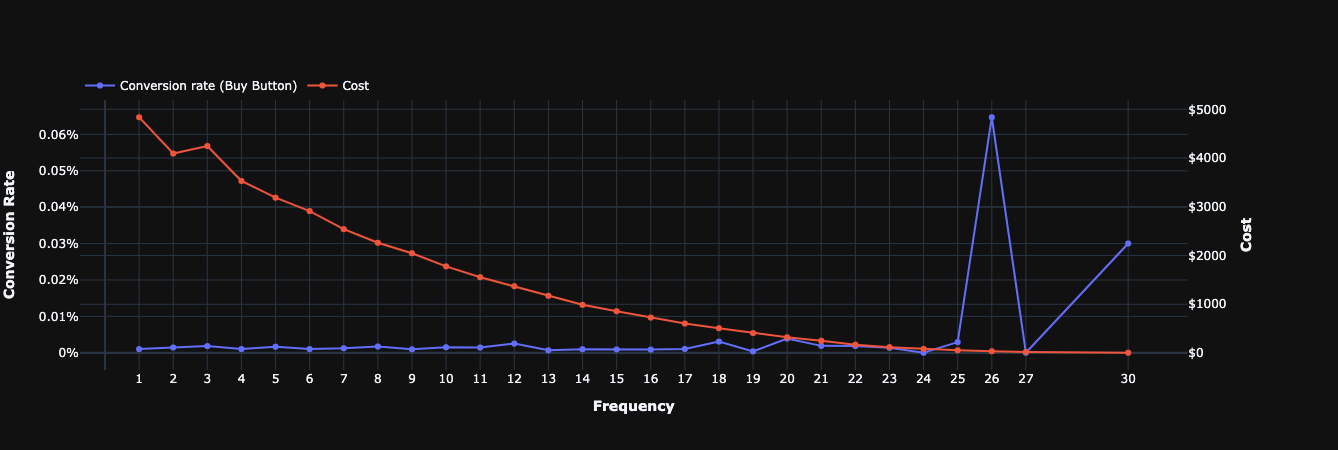

In [25]:
costs = df[['frequency', 'dv360_youtube_media_cost', 'conversion_rate']]

#fig = go.Figure()
fig = make_subplots(specs=[[{"secondary_y": True}]])


fig.add_trace(go.Scatter(x=costs.frequency, 
                         y=costs.conversion_rate,
                         mode='lines+markers',
                         name='Conversion rate (Buy Button)'), secondary_y=False)

fig.add_trace(go.Scatter(x=costs.frequency, 
                         y=costs.dv360_youtube_media_cost,
                         mode='lines+markers',
                         name='Cost'), secondary_y=True)

fig.update_layout(
    #title='<b>Conversion rate and cost vs Frequency',
    template="plotly_dark",
    xaxis = dict(
        tickmode = 'array',
        tickvals = df["frequency"],
        ticktext = df["frequency"]),
    xaxis_title="<b>Frequency</b>",
    yaxis_title="<b>Conversion rate</b>",
)

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1,
    xanchor="left",
    x=0
))

# Set y-axes titles
fig.update_yaxes(title_text="<b>Conversion Rate</b>", ticksuffix = "%", secondary_y=False)
fig.update_yaxes(title_text="<b>Cost</b>", tickprefix = "$", secondary_y=True)



In [26]:
costs = df[['frequency', 'total_conversions', 'dv360_clicks_cost', 'dv360_youtube_media_cost', 'conversion_rate']].copy()
costs['CPA'] = costs.loc[:,'dv360_youtube_media_cost']/costs.loc[:,'total_conversions']
costs

frequency  total_conversions  dv360_clicks_cost  dv360_youtube_media_cost  \
2         1.0                 34            3102.64                   4836.83   
3         2.0                 34            2841.27                   4092.15   
4         3.0                 40            2679.61                   4246.14   
5         4.0                 20            2501.37                   3529.65   
6         5.0                 30            2305.65                   3186.67   
7         6.0                 17            2149.37                   2912.10   
8         7.0                 19            1946.61                   2540.47   
9         8.0                 24            1750.57                   2261.49   
10        9.0                 12            1595.19                   2047.31   
11       10.0                 17            1411.71                   1777.59   
12       11.0                 14            1242.21                   1555.08   
13       12.0                 22            1103.08                   1370.73   
14       13.0                  5             948.46                   1173.87   
15       14.0                  6             804.30                    988.16   
16       15.0                  5             704.46                    858.02   
17       16.0                  4             600.05                    727.16   
18       17.0                  4             503.87                    604.83   
19       18.0                 10             427.76                    509.10   
20       19.0                  1             341.58                    409.32   
21       20.0                  8             268.22                    322.13   
22       21.0                  3             210.35                    251.78   
23       22.0                  2             139.18                    172.14   
24       23.0                  1              94.84                    119.74   
25       24.0                  0              64.50                     83.55   
26       25.0                  1              43.05                     56.45   
27       26.0                 14              27.60                     36.42   
28       27.0                  0              16.26                     21.87   
29       30.0                  1               4.22                      5.58   

    conversion_rate         CPA  
2           0.00101  142.259706  
3           0.00144  120.357353  
4           0.00183  106.153500  
5           0.00102  176.482500  
6           0.00165  106.222333  
7           0.00100  171.300000  
8           0.00123  133.708947  
9           0.00172   94.228750  
10          0.00094  170.609167  
11          0.00151  104.564118  
12          0.00142  111.077143  
13          0.00252   62.305909  
14          0.00067  234.774000  
15          0.00095  164.693333  
16          0.00091  171.604000  
17          0.00086  181.790000  
18          0.00103  151.207500  
19          0.00306   50.910000  
20          0.00038  409.320000  
21          0.00390   40.266250  
22          0.00189   83.926667  
23          0.00185   86.070000  
24          0.00136  119.740000  
25          0.00000         inf  
26          0.00293   56.450000  
27          0.06472    2.601429  
28          0.00000         inf  
29          0.03003    5.580000

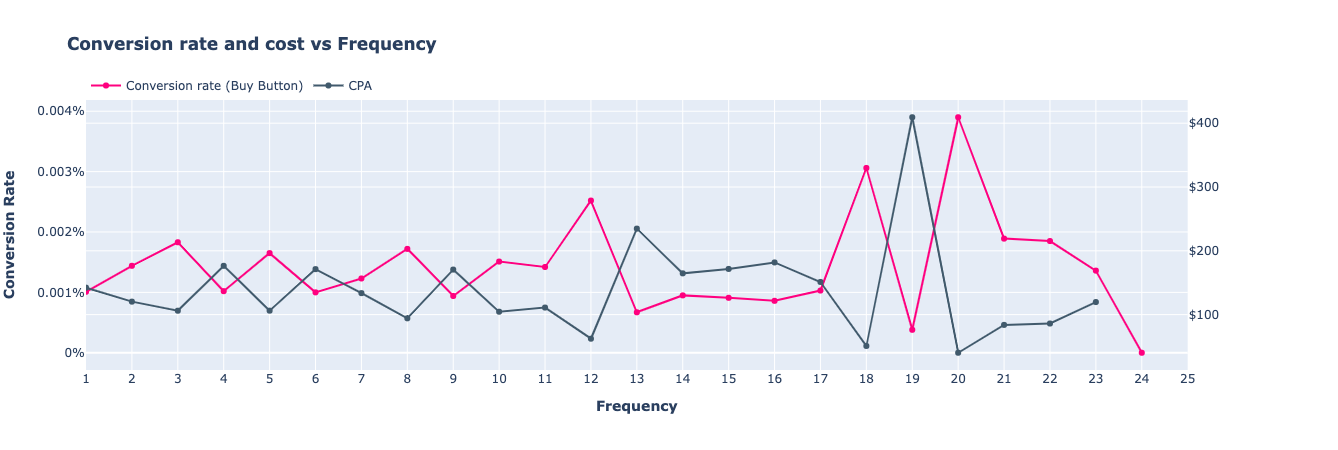

In [39]:
costs = df[['frequency', 'total_conversions', 'dv360_clicks_cost', 'dv360_youtube_media_cost', 'conversion_rate']].copy()
costs['CPA'] = costs.loc[:,'dv360_youtube_media_cost']/costs.loc[:,'total_conversions']
costs = costs.loc[0:25,:]
#fig = go.Figure()
fig = make_subplots(specs=[[{"secondary_y": True}]])


fig.add_trace(go.Scatter(x=costs.frequency, 
                         y=costs.conversion_rate,
                         mode='lines+markers',
                         name='Conversion rate (Buy Button)', marker_color='#ff007f'), secondary_y=False)


fig.add_trace(go.Scatter(x=costs.frequency, 
                         y=costs.CPA,
                         mode='lines+markers',
                         name='CPA', marker_color='#415a6c'), secondary_y=True)

# % Conversions (Buy Button)
#fig.add_trace(go.Scatter(x=costs.frequency, 
#                         y=costs.total_conversions/costs.total_conversions.sum()*100,
#                         mode='lines+markers',
#                         name='% Conversions (Buy Button)', marker_color='#f0cd28'), secondary_y=True)

# % Cost
#fig.add_trace(go.Scatter(x=costs.frequency, 
#                         y=costs.dv360_youtube_media_cost/costs.dv360_youtube_media_cost.sum()*100,
#                         mode='lines+markers',
#                         name='% Cost', marker_color='#415a6c'), secondary_y=True)



fig.update_layout(
    title='<b>Conversion rate and cost vs Frequency',
    #template="plotly_dark",
    xaxis = dict(
        tickmode = 'array',
        tickvals = df["frequency"],
        ticktext = df["frequency"]),
    xaxis_title="<b>Frequency</b>",
    yaxis_title="<b>Conversion rate</b>",
    xaxis_range=[1,25]
)

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1,
    xanchor="left",
    x=0
))


# Set y-axes titles
fig.update_yaxes(title_text="<b>Conversion Rate</b>", ticksuffix = "%", secondary_y=False)
fig.update_yaxes(tickprefix = "$", secondary_y=True)

### Cost per conversion


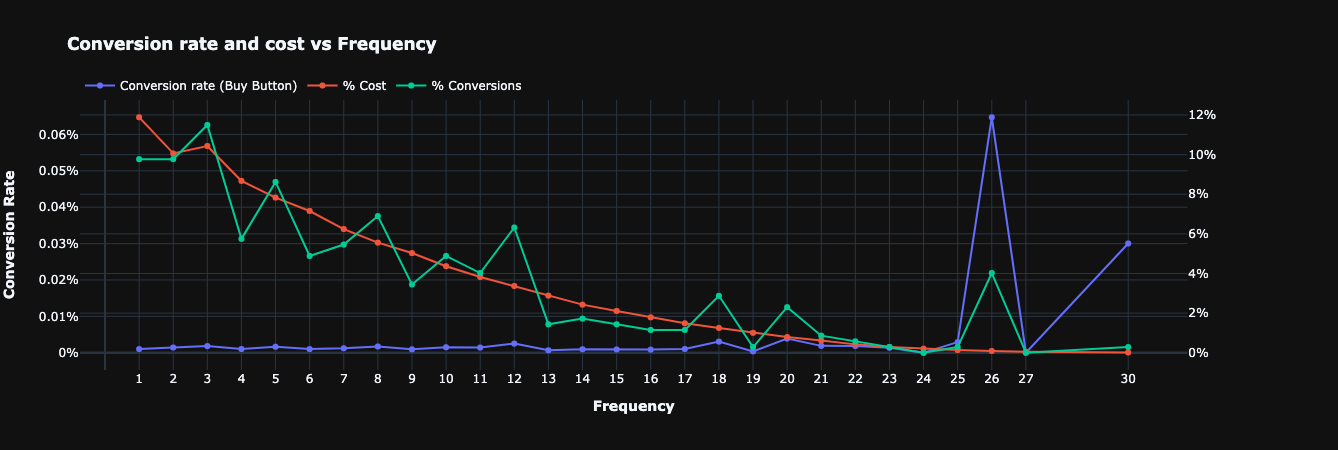

In [28]:
costs = df[['frequency', 'total_conversions', 'dv360_youtube_media_cost', 'conversion_rate']]

#fig = go.Figure()
fig = make_subplots(specs=[[{"secondary_y": True}]])


fig.add_trace(go.Scatter(x=costs.frequency, 
                         y=costs.conversion_rate,
                         mode='lines+markers',
                         name='Conversion rate (Buy Button)'), secondary_y=False)

fig.add_trace(go.Scatter(x=costs.frequency, 
                         y=costs.dv360_youtube_media_cost/costs.dv360_youtube_media_cost.sum()*100,
                         mode='lines+markers',
                         name='% Cost'), secondary_y=True)

fig.add_trace(go.Scatter(x=costs.frequency, 
                         y=costs.total_conversions/costs.total_conversions.sum()*100,
                         mode='lines+markers',
                         name='% Conversions'), secondary_y=True)

fig.update_layout(
    title='<b>Conversion rate and cost vs Frequency',
    template="plotly_dark",
    xaxis = dict(
        tickmode = 'array',
        tickvals = df["frequency"],
        ticktext = df["frequency"]),
    xaxis_title="<b>Frequency</b>",
    yaxis_title="<b>Conversion rate</b>",
)

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1,
    xanchor="left",
    x=0
))


# Set y-axes titles
fig.update_yaxes(title_text="<b>Conversion Rate</b>", ticksuffix = "%", secondary_y=False)
fig.update_yaxes(ticksuffix = "%", secondary_y=True)


# Venn Diagram Funnel

In [161]:
query = '''
SELECT * 
FROM `rb-hygiene-markets-global-prod.adh_results_apac.rc_user_overlap_dv360youtube_3_20210712_20210822_2`
'''
user_overlap = client.query(query)
user_overlap= user_overlap.to_dataframe()
user_overlap.to_csv('user_overlap.csv', index=False)

#user_overlap = pd.read_csv("user_overlap.csv")

In [162]:
user_overlap

partner_id  advertiser_id  campaign_id  users_exlusive_know  \
0   599149418      603701472      6822204              2562704   

   users_exlusive_think  users_exlusive_do  users_know_think  users_know_do  \
0               1273341             913907           1281736         269216   

   users_think_do  users_know_think_do  ...  cost_users_know_think_do  \
0          423198               754234  ...              15411.814516   

   total_impressions  total_impressions2  total_impressions3  \
0           26946048            26946048            26946048   

   total_conversions  total_conversions_summing  total_cost_in_usd  \
0                355                        355       44460.777791   

   total_cost_in_usd_summing  reach_total_users  total_users_summing  
0               44451.698134            7488342              7478336  

[1 rows x 40 columns]

##### Users overlap percentage

In [163]:
user_overlap_perc = user_overlap[['users_exlusive_know', 'users_exlusive_think', 'users_exlusive_do', 'users_know_think', 'users_know_do', 'users_think_do', 'users_know_think_do', 'reach_total_users']]
user_overlap_perc = round(user_overlap_perc/ user_overlap_perc.reach_total_users[0]*100, 1)
user_overlap_perc

users_exlusive_know  users_exlusive_think  users_exlusive_do  \
0                 34.2                  17.0               12.2   

   users_know_think  users_know_do  users_think_do  users_know_think_do  \
0              17.1            3.6             5.7                 10.1   

   reach_total_users  
0              100.0

##### Conversion rate CVR = (number of conversions / impressions) x 100


In [166]:
cvr_df = pd.DataFrame()
cvr_df['cvr_know'] = round(user_overlap.conv_users_exlusive_know/user_overlap.imp_users_exlusive_know.values*100, 4)
cvr_df['cvr_think'] = round(user_overlap.conv_users_exlusive_think/user_overlap.imp_users_exlusive_think.values*100, 4)
cvr_df['cvr_do'] = round(user_overlap.conv_users_exlusive_do/user_overlap.imp_users_exlusive_do.values*100, 4)
cvr_df['cvr_know_think'] = round(user_overlap.conv_users_know_think/user_overlap.imp_users_know_think.values*100, 4)
cvr_df['cvr_know_do'] = round(user_overlap.conv_users_know_do/user_overlap.imp_users_know_do.values*100, 4)
cvr_df['cvr_think_do'] = round(user_overlap.conv_users_think_do/user_overlap.imp_users_think_do.values*100, 4)
cvr_df['cvr_know_think_do'] = round(user_overlap.conv_users_know_think_do/user_overlap.imp_users_know_think_do.values*100, 4)
cvr_df['overall'] = round(user_overlap.total_conversions/user_overlap.total_impressions.values*100, 4)
cvr_df

cvr_know  cvr_think  cvr_do  cvr_know_think  cvr_know_do  cvr_think_do  \
0       0.0     0.0001  0.0066             0.0       0.0033        0.0032   

   cvr_know_think_do  overall  
0             0.0017   0.0013

##### Cost per Acquisiton = (cost / conversion) x 100


In [170]:
cpa_df = pd.DataFrame()
cpa_df['cpa_know'] = round(user_overlap.cost_users_exlusive_know/user_overlap.conv_users_exlusive_know.values, 0)
cpa_df['cpa_think'] = round(user_overlap.cost_users_exlusive_think/user_overlap.conv_users_exlusive_think.values, 0)
cpa_df['cpa_do'] = round(user_overlap.cost_users_exlusive_do/user_overlap.conv_users_exlusive_do.values, 0)
cpa_df['cpa_know_think'] = round(user_overlap.cost_users_know_think/user_overlap.conv_users_know_think.values, 0)
cpa_df['cpa_know_do'] = round(user_overlap.cost_users_know_do/user_overlap.conv_users_know_do.values, 0)
cpa_df['cpa_think_do'] = round(user_overlap.cost_users_think_do/user_overlap.conv_users_think_do.values, 0)
cpa_df['cpa_know_think_do'] = round(user_overlap.cost_users_know_think_do/user_overlap.conv_users_know_think_do.values, 0)
cpa_df['overall'] = round(user_overlap.total_cost_in_usd/user_overlap.total_conversions.values, 0)
cpa_df

cpa_know  cpa_think  cpa_do  cpa_know_think  cpa_know_do  cpa_think_do  \
0    5021.0      833.0    52.0          5512.0         69.0          54.0   

   cpa_know_think_do  overall  
0               97.0    125.0

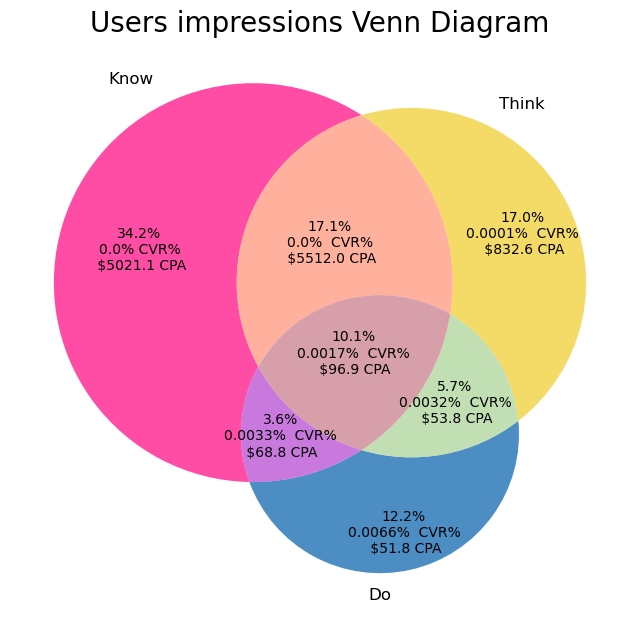

In [169]:
#help: subsets = (Abc, 
#                 aBc, 
#                 ABc, 
#                 abC, 
#                 AbC, 
#                 aBC, 
#                 ABC)
# A = know, B=think, C=do
plt.style.use(['default'])
plt.figure(figsize=(8,8), edgecolor="white")
v = venn3(subsets = (user_overlap_perc.users_exlusive_know[0], 
                 user_overlap_perc.users_exlusive_think[0], 
                 user_overlap_perc.users_know_think[0], 
                 user_overlap_perc.users_exlusive_do[0], 
                 user_overlap_perc.users_know_do[0], 
                 user_overlap_perc.users_think_do[0], 
                 user_overlap_perc.users_know_think_do[0]), set_labels = ('Know', 'Think', 'Do'), set_colors=('#ff007f', '#f0cd28', '#005daa'), alpha = 0.7)

#marker_color='#ff007f' marker_color='#f0cd28' marker_color='#005daa'

plt.title("Users impressions Venn Diagram", fontsize=20)

# setting color of id 11 to purple
#v.get_patch_by_id('11').set_color('purple')
#setting label of id 10 to New Text
v.get_label_by_id('100').set_text(str(user_overlap_perc.users_exlusive_know[0])  + '%\n' + str(cvr_df.cvr_know[0]) + '% CVR' + '%\n $' + str(cpa_df.cpa_know[0]) + ' CPA')
v.get_label_by_id('010').set_text(str(user_overlap_perc.users_exlusive_think[0]) + '%\n' + str(cvr_df.cvr_think[0]) + '%  CVR' + '%\n $' + str(cpa_df.cpa_think[0]) + ' CPA' )
v.get_label_by_id('110').set_text(str(user_overlap_perc.users_know_think[0])     + '%\n' + str(cvr_df.cvr_know_think[0]) + '%  CVR' + '%\n $' + str(cpa_df.cpa_know_think[0]) + ' CPA' )
v.get_label_by_id('001').set_text(str(user_overlap_perc.users_exlusive_do[0])    + '%\n' + str(cvr_df.cvr_do[0]) + '%  CVR' + '%\n $' + str(cpa_df.cpa_do[0]) + ' CPA' )
v.get_label_by_id('101').set_text(str(user_overlap_perc.users_know_do[0])        + '%\n' + str(cvr_df.cvr_know_do[0]) + '%  CVR' + '%\n $' + str(cpa_df.cpa_know_do[0]) + ' CPA')
v.get_label_by_id('011').set_text(str(user_overlap_perc.users_think_do[0])       + '%\n' + str(cvr_df.cvr_think_do[0]) + '%  CVR' + '%\n $' + str(cpa_df.cpa_think_do[0]) + ' CPA')
v.get_label_by_id('111').set_text(str(user_overlap_perc.users_know_think_do[0])  + '%\n' + str(cvr_df.cvr_know_think_do[0]) + '%  CVR' + '%\n $' + str(cpa_df.cpa_know_think_do[0]) + ' CPA')

plt.show()

# Conversion: click floodlight landing page + click_to_advertiser_site

In [98]:
client = bigquery.Client()

In [99]:
client

### Frequency Range Metrics

In [9]:
query = '''
SELECT * 
FROM `rb-hygiene-markets-global-prod.adh_results_apac.rc_groupg19_freq_imp_pageviews_conv_dv360youtube_1_20210712_20210822_1`
'''
df = client.query(query)
df= df.to_dataframe()
df.to_csv('df.csv', index=False)

#df = pd.read_csv("df.csv")
df.head(5)

partner_id  advertiser_id  campaign_id  frequency    reach  \
0   599149418      603701472      6822204          0    32830   
1   599149418      603701472      6822204          1  3377512   
2   599149418      603701472      6822204          2  1183311   
3   599149418      603701472      6822204          3   728105   
4   599149418      603701472      6822204          4   489773   

   total_impressions  total_clicks  total_conversions  total_imp_know  \
0                  0         16006                 69               0   
1            3377512       1326149               3795          837925   
2            2366622       1239732               2594          770798   
3            2184315       1285639               2542          780163   
4            1959092       1184740               2512          777392   

   total_imp_think  ...  perc_imp_know  perc_imp_think  perc_imp_do  \
0                0  ...            NaN             NaN          NaN   
1          1863329  ...         24.809          55.169       20.022   
2          1162908  ...         32.570          49.138       18.293   
3           926088  ...         35.717          42.397       21.886   
4           778159  ...         39.681          39.720       20.598   

   perc_conv_know  perc_conv_think  perc_conv_do  conversion_rate  \
0          42.029           26.087        31.884              NaN   
1          45.112           24.427        30.514          0.11236   
2          35.698           25.289        39.052          0.10961   
3          25.138           22.620        52.478          0.11638   
4          20.462           22.412        57.484          0.12822   

   dv360_youtube_media_cost  dv360_imp_cost  dv360_clicks_cost  
0                      9.05            0.00               9.05  
1                   4836.83         1734.19            3102.64  
2                   4092.15         1250.88            2841.27  
3                   4246.14         1566.53            2679.61  
4                   3529.65         1028.28            2501.37  

[5 rows x 24 columns]

In [10]:
df_an = df[['frequency','reach', 'total_impressions','total_clicks','total_conversions','dv360_youtube_media_cost']]
df_an = df_an[df_an.frequency > 0]
summary = pd.DataFrame(df_an.iloc[:,1::].sum(), columns=['Sum']).transpose()
summary

reach  total_impressions  total_clicks  total_conversions  \
Sum  7490154.0         26946048.0    15269707.0            32629.0   

     dv360_youtube_media_cost  
Sum                  44451.73

In [11]:
# create a list of our conditions
conditions = [
    (df_an['frequency'] == 1),
    (df_an['frequency'] > 1)  & (df_an['frequency'] <= 6),
    (df_an['frequency'] > 6)  & (df_an['frequency'] <= 12),
    (df_an['frequency'] > 12) & (df_an['frequency'] <= 18),
    (df_an['frequency'] > 18)
    ]

# create a list of the values we want to assign for each condition
values = ['1', '2-6', '7-12', '13-18', '19-30']

# create a new column and use np.select to assign values to it using our lists as arguments
df_an['frequency_range'] = np.select(conditions, values)

# display updated DataFrame
df_an = df_an[['frequency_range','reach', 'total_impressions','total_clicks','total_conversions','dv360_youtube_media_cost']].groupby(by='frequency_range').sum()
df_an = round(df_an/df_an.sum()*100,1)
df_an

reach  total_impressions  total_clicks  total_conversions  \
frequency_range                                                              
1                 45.1               12.5           8.7               11.6   
13-18              2.8               11.6          12.5               14.0   
19-30              0.6               12.0          12.2                4.7   
2-6               40.7               37.2          38.2               38.3   
7-12              10.8               26.7          28.5               31.4   

                 dv360_youtube_media_cost  
frequency_range                            
1                                    10.9  
13-18                                10.9  
19-30                                11.8  
2-6                                  40.4  
7-12                                 26.0

In [12]:
df_an.sum()

reach                       100.0
total_impressions           100.0
total_clicks                100.1
total_conversions           100.0
dv360_youtube_media_cost    100.0
dtype: float64

Conversion Rate and CPA

In [13]:
df_an = df[['frequency','reach', 'total_impressions','total_clicks','total_conversions','dv360_youtube_media_cost']]
df_an = df_an[df_an.frequency > 0]
summary = pd.DataFrame(df_an.iloc[:,1::].sum(), columns=['Sum']).transpose()
summary

reach  total_impressions  total_clicks  total_conversions  \
Sum  7490154.0         26946048.0    15269707.0            32629.0   

     dv360_youtube_media_cost  
Sum                  44451.73

In [105]:
# create a list of our conditions
conditions = [
    (df_an['frequency'] == 1),
    (df_an['frequency'] > 1)  & (df_an['frequency'] <= 6),
    (df_an['frequency'] > 6)  & (df_an['frequency'] <= 12),
    (df_an['frequency'] > 12) & (df_an['frequency'] <= 18),
    (df_an['frequency'] > 18)
    ]

# create a list of the values we want to assign for each condition
values = ['1', '2-6', '7-12', '13-18', '19-30']

# create a new column and use np.select to assign values to it using our lists as arguments
df_an['frequency_range'] = np.select(conditions, values)

# display updated DataFrame
df_an = df_an[['frequency_range','reach', 'total_impressions','total_clicks','total_conversions','dv360_youtube_media_cost']].groupby(by='frequency_range').sum()
#df_an = round(df_an/df_an.sum()*100,1)
df_an

reach  total_impressions  total_clicks  total_conversions  \
frequency_range                                                                
1                3377512            3377512       1326149               3795   
13-18             209790            3115881       1904387               4556   
19-30              45101            3238417       1856537               1546   
2-6              3047414           10024335       5837196              12483   
7-12              810337            7189903       4345438              10249   

                 dv360_youtube_media_cost  
frequency_range                            
1                                 4836.83  
13-18                             4861.14  
19-30                             5234.38  
2-6                              17966.71  
7-12                             11552.67

In [106]:
df_an['cvr'] = df_an.total_conversions/ df_an.total_impressions*100
df_an['CPA'] = df_an.dv360_youtube_media_cost/ df_an.total_conversions

df_an

reach  total_impressions  total_clicks  total_conversions  \
frequency_range                                                                
1                3377512            3377512       1326149               3795   
13-18             209790            3115881       1904387               4556   
19-30              45101            3238417       1856537               1546   
2-6              3047414           10024335       5837196              12483   
7-12              810337            7189903       4345438              10249   

                 dv360_youtube_media_cost       cvr       CPA  
frequency_range                                                
1                                 4836.83  0.112361  1.274527  
13-18                             4861.14  0.146219  1.066975  
19-30                             5234.38  0.047739  3.385757  
2-6                              17966.71  0.124527  1.439294  
7-12                             11552.67  0.142547  1.127200

### Frequency Range Metrics at Funnel Level

In [117]:
query = '''
SELECT * 
FROM `rb-hygiene-markets-global-prod.adh_results_apac.rc_groupover13_freq_imp_pageview_conv_filteringconvertedusers_dv360youtube_1_20210712_20210822_1`
'''
df = client.query(query)
df= df.to_dataframe()
df.to_csv('df.csv', index=False)

#df = pd.read_csv("df.csv")
df

partner_id  advertiser_id  campaign_id  frequency  reach  \
0           NaN            NaN          NaN        NaN    797   
1   599149418.0    603701472.0    6822204.0        0.0     69   
2   599149418.0    603701472.0    6822204.0        1.0   3795   
3   599149418.0    603701472.0    6822204.0        2.0   2594   
4   599149418.0    603701472.0    6822204.0        3.0   2542   
5   599149418.0    603701472.0    6822204.0        4.0   2512   
6   599149418.0    603701472.0    6822204.0        5.0   2519   
7   599149418.0    603701472.0    6822204.0        6.0   2316   
8   599149418.0    603701472.0    6822204.0        7.0   2117   
9   599149418.0    603701472.0    6822204.0        8.0   1997   
10  599149418.0    603701472.0    6822204.0        9.0   1796   
11  599149418.0    603701472.0    6822204.0       10.0   1637   
12  599149418.0    603701472.0    6822204.0       11.0   1408   
13  599149418.0    603701472.0    6822204.0       12.0   1294   
14  599149418.0    603701472.0    6822204.0       13.0   1139   
15  599149418.0    603701472.0    6822204.0       14.0    929   
16  599149418.0    603701472.0    6822204.0       15.0    789   
17  599149418.0    603701472.0    6822204.0       16.0    682   
18  599149418.0    603701472.0    6822204.0       17.0    558   
19  599149418.0    603701472.0    6822204.0       18.0    459   
20  599149418.0    603701472.0    6822204.0       19.0    383   
21  599149418.0    603701472.0    6822204.0       20.0    315   
22  599149418.0    603701472.0    6822204.0       26.0     51   

    total_impressions  total_clicks  total_conversions  total_imp_know  \
0             2312333       1251293               1682   810878.261866   
1                   0            76                 92        0.000000   
2                3795          4223               5036        0.244532   
3                5188          4286               3619        0.546261   
4                7626          6235               3585        0.785995   
5               10048          7929               3469        1.141322   
6               12595          9501               3552        1.557761   
7               13896         10102               3242        2.066494   
8               14819         10629               3086        2.591875   
9               15976         11228               2772        3.204807   
10              16164         11244               2534        3.724944   
11              16370         11121               2475        4.319487   
12              15488         10422               2072        4.813920   
13              15528         10758               1936        5.346986   
14              14807         10161               1671        5.850746   
15              13006          9020               1367        6.260495   
16              11835          8158               1323        6.690748   
17              10912          7395                972        6.907625   
18               9486          6408                787        7.096774   
19               8262          5536                686        7.522876   
20               7277          4916                557        7.819843   
21               6300          4254                464        8.266667   
22               1326           991                105        9.901961   

    total_imp_think   total_imp_do  total_imp_per_user  
0     869267.139923  614205.598211                 NaN  
1          0.000000       0.000000                 0.0  
2          0.451383       0.304084                 1.0  
3          0.801079       0.652660                 2.0  
4          0.929583       1.284422                 3.0  
5          1.113455       1.745223                 4.0  
6          1.261215       2.181024                 5.0  
7          1.464162       2.469344                 6.0  
8          1.746812       2.661313                 7.0  
9          1.894342       2.900851                 8.0  
10         2.129176       3.145880      

In [128]:
df_13_18 = df[(df['frequency']>=13) & (df['frequency']<=18)]
df_13_18 = df_13_18[['frequency', 'total_impressions', 'total_imp_know', 'total_imp_think', 'total_imp_do']]
df_13_18['perc_impressions'] = df_13_18['total_impressions']/df_13_18['total_impressions'].sum()
df_13_18

frequency  total_impressions  total_imp_know  total_imp_think  \
14       13.0              14807        5.850746         3.258121   
15       14.0              13006        6.260495         3.670614   
16       15.0              11835        6.690748         3.922687   
17       16.0              10912        6.907625         4.739003   
18       17.0               9486        7.096774         5.541219   
19       18.0               8262        7.522876         5.949891   

    total_imp_do  perc_impressions  
14      3.891133          0.216768  
15      4.068891          0.190402  
16      4.386565          0.173259  
17      4.353372          0.159747  
18      4.362007          0.138871  
19      4.527233          0.120952

In [139]:
avg_df = pd.DataFrame()
avg_df['imp_know'] = df_13_18['total_imp_know']*df_13_18['perc_impressions']
avg_df['imp_think'] = df_13_18['total_imp_think']*df_13_18['perc_impressions']
avg_df['imp_do'] = df_13_18['total_imp_do']*df_13_18['perc_impressions']
avg_df.sum()

imp_know     6.618420
imp_think    4.331001
imp_do       4.226987
dtype: float64

### Plot Analysis

In [110]:
query = '''
SELECT * 
FROM `rb-hygiene-markets-global-prod.adh_results_apac.rc_freq_imp_pageviews_conv_dv360youtube_1_20210712_20210822_2`
'''
df = client.query(query)
df= df.to_dataframe()
df.to_csv('df.csv', index=False)

#df = pd.read_csv("df.csv")
df

partner_id  advertiser_id  campaign_id  frequency    reach  \
0           NaN            NaN          NaN        NaN      509   
1   599149418.0    603701472.0    6822204.0        0.0    32830   
2   599149418.0    603701472.0    6822204.0        1.0  3377512   
3   599149418.0    603701472.0    6822204.0        2.0  1183311   
4   599149418.0    603701472.0    6822204.0        3.0   728105   
5   599149418.0    603701472.0    6822204.0        4.0   489773   
6   599149418.0    603701472.0    6822204.0        5.0   363044   
7   599149418.0    603701472.0    6822204.0        6.0   283181   
8   599149418.0    603701472.0    6822204.0        7.0   219863   
9   599149418.0    603701472.0    6822204.0        8.0   173978   
10  599149418.0    603701472.0    6822204.0        9.0   141394   
11  599149418.0    603701472.0    6822204.0       10.0   112448   
12  599149418.0    603701472.0    6822204.0       11.0    89836   
13  599149418.0    603701472.0    6822204.0       12.0    72818   
14  599149418.0    603701472.0    6822204.0       13.0    57597   
15  599149418.0    603701472.0    6822204.0       14.0    45248   
16  599149418.0    603701472.0    6822204.0       15.0    36695   
17  599149418.0    603701472.0    6822204.0       16.0    29181   
18  599149418.0    603701472.0    6822204.0       17.0    22915   
19  599149418.0    603701472.0    6822204.0       18.0    18154   
20  599149418.0    603701472.0    6822204.0       19.0    13728   
21  599149418.0    603701472.0    6822204.0       20.0    10267   
22  599149418.0    603701472.0    6822204.0       21.0     7575   
23  599149418.0    603701472.0    6822204.0       22.0     4911   
24  599149418.0    603701472.0    6822204.0       23.0     3207   
25  599149418.0    603701472.0    6822204.0       24.0     2123   
26  599149418.0    603701472.0    6822204.0       25.0     1364   
27  599149418.0    603701472.0    6822204.0       26.0      832   
28  599149418.0    603701472.0    6822204.0       27.0      474   
29  599149418.0    603701472.0    6822204.0       30.0      111   

    total_impressions  total_clicks  total_conversions  total_imp_know  \
0             2308555       1249903                 30          816242   
1                   0         16006                 69               0   
2             3377512       1326149               3795          837925   
3             2366622       1239732               2594          770798   
4             2184315       1285639               2542          780163   
5             1959092       1184740               2512          777392   
6             1815220       1106924               2519          768497   
7             1699086       1020161               2316          756112   
8             1539041        925852               2117          716577   
9             1391824        839193               1997          663526   
10            1272546        767770               1796          615084   
11            1124480        680861               1637          546220   
12             988196        599489               1408          479396   
13             873816        532273               1294          422362   
14             748761        456380               1139          358057   
15             633472        386609                929          299357   
16             550425        335497                789          255930   
17             466896        285556                682          213506   
18             389555        238830                558          175393   
19             326772        201515                459          145350   
20             260832        163483                383          113938   
21             205340        130843                315           88272   
22             159075        102791                228           67254   
23             108042         71342                197           44722   
24              73761         50315                129           29804   
25 

In [14]:
df['total_conversions'].sum()

32698

In [59]:
df = df[df.frequency > 0]
df['cumsum_reach'] = df['reach'].cumsum()
df['cumsum_imp'] = df['total_impressions'].cumsum()
df['cumsum_conv'] = df['total_conversions'].cumsum()
df['cumsum_cost'] = df['dv360_youtube_media_cost'].cumsum()
df['cumsum_imp_cost'] = df['dv360_imp_cost'].cumsum()
df['cumsum_click_cost'] = df['dv360_clicks_cost'].cumsum()
df

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

partner_id  advertiser_id  campaign_id  frequency    reach  \
2   599149418.0    603701472.0    6822204.0        1.0  3377512   
3   599149418.0    603701472.0    6822204.0        2.0  1183311   
4   599149418.0    603701472.0    6822204.0        3.0   728105   
5   599149418.0    603701472.0    6822204.0        4.0   489773   
6   599149418.0    603701472.0    6822204.0        5.0   363044   
7   599149418.0    603701472.0    6822204.0        6.0   283181   
8   599149418.0    603701472.0    6822204.0        7.0   219863   
9   599149418.0    603701472.0    6822204.0        8.0   173978   
10  599149418.0    603701472.0    6822204.0        9.0   141394   
11  599149418.0    603701472.0    6822204.0       10.0   112448   
12  599149418.0    603701472.0    6822204.0       11.0    89836   
13  599149418.0    603701472.0    6822204.0       12.0    72818   
14  599149418.0    603701472.0    6822204.0       13.0    57597   
15  599149418.0    603701472.0    6822204.0       14.0    45248   
16  599149418.0    603701472.0    6822204.0       15.0    36695   
17  599149418.0    603701472.0    6822204.0       16.0    29181   
18  599149418.0    603701472.0    6822204.0       17.0    22915   
19  599149418.0    603701472.0    6822204.0       18.0    18154   
20  599149418.0    603701472.0    6822204.0       19.0    13728   
21  599149418.0    603701472.0    6822204.0       20.0    10267   
22  599149418.0    603701472.0    6822204.0       21.0     7575   
23  599149418.0    603701472.0    6822204.0       22.0     4911   
24  599149418.0    603701472.0    6822204.0       23.0     3207   
25  599149418.0    603701472.0    6822204.0       24.0     2123   
26  599149418.0    603701472.0    6822204.0       25.0     1364   
27  599149418.0    603701472.0    6822204.0       26.0      832   
28  599149418.0    603701472.0    6822204.0       27.0      474   
29  599149418.0    603701472.0    6822204.0       30.0      111   

    total_impressions  total_clicks  total_conversions  total_imp_know  \
2             3377512       1326149               3795          837925   
3             2366622       1239732               2594          770798   
4             2184315       1285639               2542          780163   
5             1959092       1184740               2512          777392   
6             1815220       1106924               2519          768497   
7             1699086       1020161               2316          756112   
8             1539041        925852               2117          716577   
9             1391824        839193               1997          663526   
10            1272546        767770               1796          615084   
11            1124480        680861               1637          546220   
12             988196        599489               1408          479396   
13             873816        532273               1294          422362   
14             748761        456380               1139          358057   
15             633472        386609                929          299357   
16             550425        335497                789          255930   
17             466896        285556                682          213506   
18             389555        238830                558          175393   
19             326772        201515                459          145350   
20             260832        163483                383          113938   
21             205340        130843                315           88272   
22             159075        102791                228           67254   
23             108042         71342                197           44722   
24              73761         50315                129           29804   
25              50952         35522                105           20098   
26              34100         24295                 73           13169   
27              21632         15924                 51            8262   
28              12798          9527                 31         

### Bar plot with count values

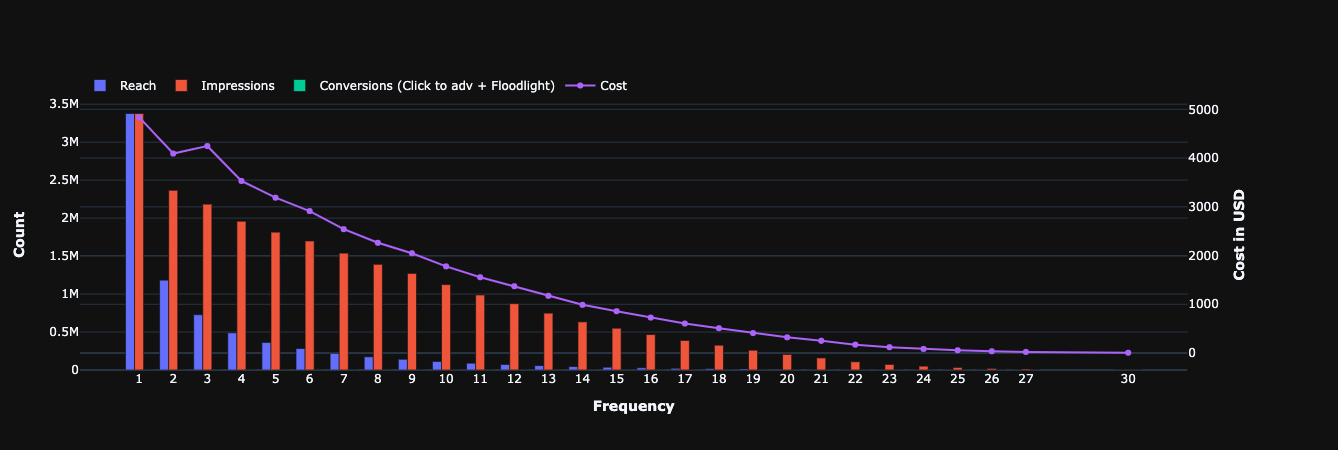

In [64]:
#fig = go.Figure()
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Bar(x=df.frequency,
                     y=df["reach"],
                     name="Reach"), secondary_y=False,)

fig.add_trace(go.Bar(x=df.frequency,
                     y=df["total_impressions"],
                     name="Impressions"), secondary_y=False,)

fig.add_trace(go.Bar(x=df.frequency,
                     y=df["total_conversions"],
                     name="Conversions (Click to adv + Floodlight)"), secondary_y=False,)

fig.add_trace(go.Scatter(x=df.frequency, y=df.dv360_youtube_media_cost,
                    mode='lines+markers',
                    name='Cost'), secondary_y=True,)


fig.update_layout(
    #title='<b>Reach & Impressions & Conversions - Buy </b>',
    template="plotly_dark",
    xaxis = dict(
        tickmode = 'array',
        tickvals = df["frequency"],
        ticktext = df["frequency"]),
    xaxis_title="<b>Frequency</b>",
)

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1,
    xanchor="left",
    x=0
))

# Set y-axes titles
fig.update_yaxes(title_text="<b>Count</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>Cost in USD</b>", secondary_y=True)

### Bar plot with cumulative values

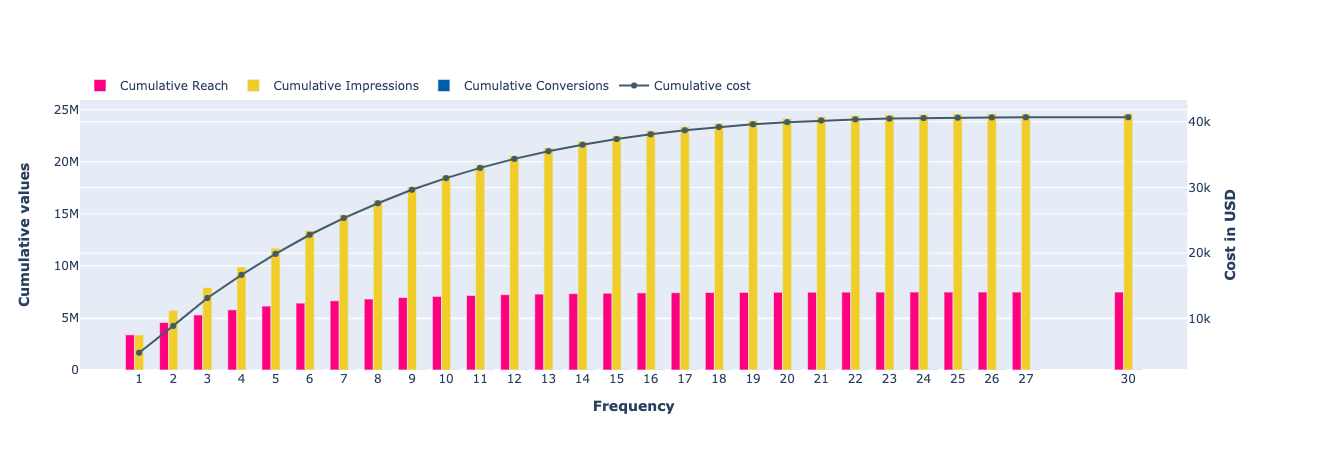

In [65]:
#fig = go.Figure()
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Bar(x=df.frequency,
                     y=df["cumsum_reach"],
                     name="Cumulative Reach", marker_color='#ff007f'), secondary_y=False,)

fig.add_trace(go.Bar(x=df.frequency,
                     y=df["cumsum_imp"],
                     name="Cumulative Impressions", marker_color='#f0cd28'), secondary_y=False,)

#I don't add this trace because it is so small that it only appears in the legends

fig.add_trace(go.Bar(x=df.frequency,
                     y=df["cumsum_conv"],
                     name="Cumulative Conversions", marker_color='#005daa'), secondary_y=False,)

fig.add_trace(go.Scatter(x=df.frequency, y=df.cumsum_cost,
                    mode='lines+markers',
                    name='Cumulative cost', marker_color='#415a6c'), secondary_y=True,)


fig.update_layout(
    #title='<b>Bar plot with cumulative values</b>',
    #template="plotly_dark",
    xaxis = dict(
        tickmode = 'array',
        tickvals = df["frequency"],
        ticktext = df["frequency"]),
    xaxis_title="<b>Frequency</b>",
)

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1,
    xanchor="left",
    x=0
))

# Set y-axes titles
fig.update_yaxes(title_text="<b>Cumulative values</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>Cost in USD</b>", secondary_y=True)

### Bar plot with percentage count values

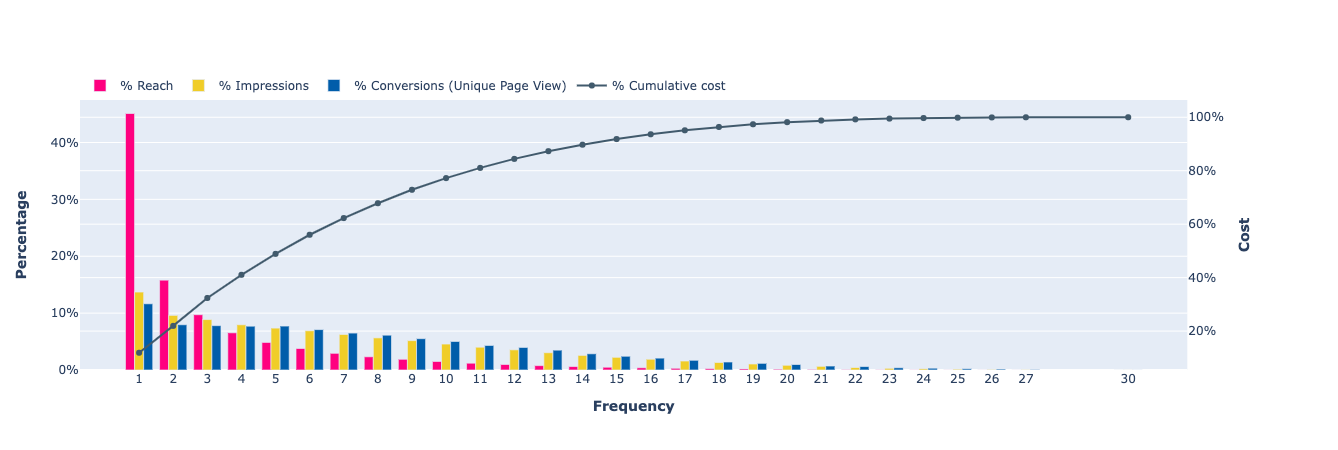

In [66]:
#fig = go.Figure()
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Bar(x=df.frequency,
                     y=df["reach"]/df["cumsum_reach"].max()*100,
                     name="% Reach", marker_color='#ff007f'), 
                     secondary_y=False)

fig.add_trace(go.Bar(x=df.frequency,
                     y=df["total_impressions"]/df["cumsum_imp"].max()*100,
                     name="% Impressions", marker_color='#f0cd28'),
                     secondary_y=False)

fig.add_trace(go.Bar(x=df.frequency,
                     y=df["total_conversions"]/df["cumsum_conv"].max()*100,
                     name="% Conversions (Unique Page View)", marker_color='#005daa'),
                     secondary_y=False,)

fig.add_trace(go.Scatter(x=df.frequency, 
                         y=df.cumsum_cost/df.cumsum_cost.max()*100,
                         mode='lines+markers',
                         name='% Cumulative cost', marker_color='#415a6c'),
                         secondary_y=True,)


fig.update_layout(
    #title='<b>Bar plot with percentage count values</b>',
    #template="plotly_dark",
    xaxis = dict(
        tickmode = 'array',
        tickvals = df["frequency"],
        ticktext = df["frequency"]),
    xaxis_title="<b>Frequency</b>",
)


fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1,
    xanchor="left",
    x=0
))

# Set y-axes titles
fig.update_yaxes(title_text="<b>Percentage</b>", ticksuffix = "%", secondary_y=False)
fig.update_yaxes(title_text="<b>Cost</b>", ticksuffix = "%", secondary_y=True)

### Bar plot with cumulative percentages

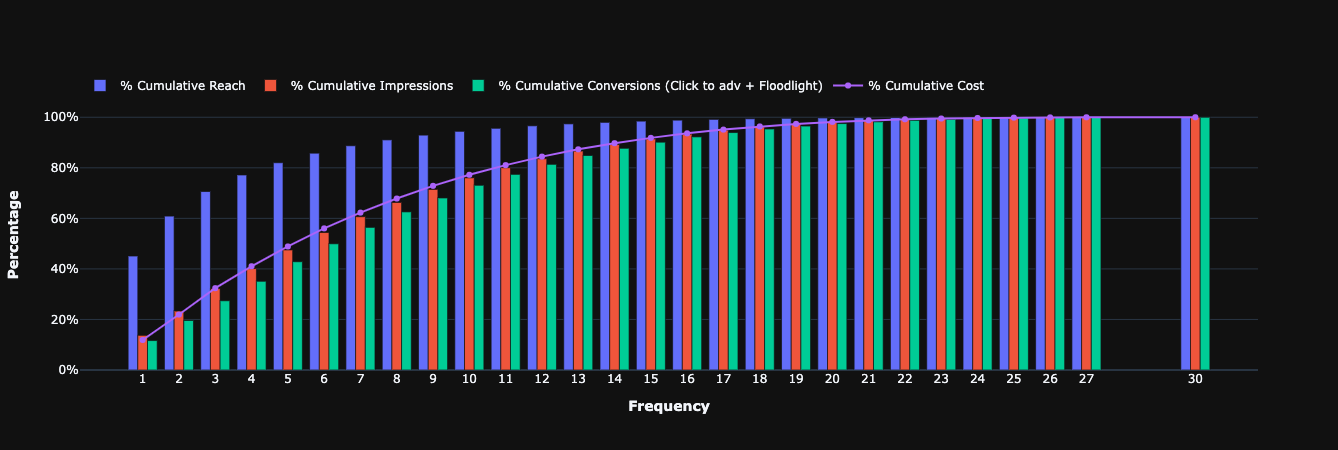

In [67]:
fig = go.Figure()


fig.add_trace(go.Bar(x=df.frequency,
                     y=df["cumsum_reach"]/df["cumsum_reach"].max()*100,
                     name="% Cumulative Reach"))

fig.add_trace(go.Bar(x=df.frequency,
                     y=df["cumsum_imp"]/df["cumsum_imp"].max()*100,
                     name="% Cumulative Impressions"))

fig.add_trace(go.Bar(x=df.frequency,
                     y=df["cumsum_conv"]/df["cumsum_conv"].max()*100,
                     name="% Cumulative Conversions (Click to adv + Floodlight)"))

fig.add_trace(go.Scatter(x=df.frequency, 
                         y=df.cumsum_cost/df.cumsum_cost.max()*100,
                         mode='lines+markers',
                         name='% Cumulative Cost'))


fig.update_layout(
    #title='<b>Bar plot with percentage values</b>',
    template="plotly_dark",
    xaxis = dict(
        tickmode = 'array',
        tickvals = df["frequency"],
        ticktext = df["frequency"]),
    xaxis_title="<b>Frequency</b>",
)

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1,
    xanchor="left",
    x=0
))

# Set y-axes titles
fig.update_yaxes(title_text="<b>Percentage</b>", ticksuffix = "%")


### Funnel impressions

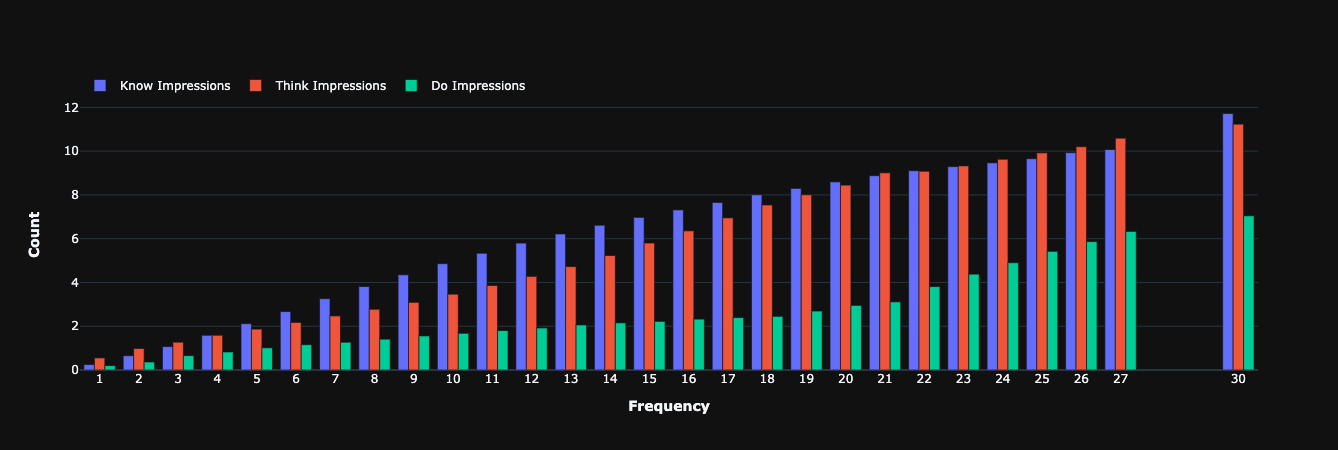

In [68]:
fig = go.Figure()

fig.add_trace(go.Bar(x=df.frequency,
                     y=df.total_imp_know/df.total_impressions*df.frequency,
                     name="Know Impressions"))

fig.add_trace(go.Bar(x=df.frequency,
                     y=df.total_imp_think/df.total_impressions*df.frequency,
                     name="Think Impressions"))

fig.add_trace(go.Bar(x=df.frequency,
                     y=df.total_imp_do/df.total_impressions*df.frequency,
                     name="Do Impressions"))


fig.update_layout(
    #title='<b>Reach & Impressions & Conversions - Buy </b>',
    template="plotly_dark",
    xaxis = dict(
        tickmode = 'array',
        tickvals = df["frequency"],
        ticktext = df["frequency"]),
    xaxis_title="<b>Frequency</b>",
)

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1,
    xanchor="left",
    x=0
))

# Set y-axes titles
fig.update_yaxes(title_text="<b>Count</b>")

In [69]:
aux = df.loc[(df.frequency>=7) & (df.frequency<=16)][['frequency', 'total_impressions', 'total_imp_know', 'total_imp_think', 'total_imp_do']]
aux['know_count'] =aux.total_imp_know/aux.total_impressions
aux['think_count'] =aux.total_imp_think/aux.total_impressions
aux['do_count'] =aux.total_imp_do/aux.total_impressions
aux

frequency  total_impressions  total_imp_know  total_imp_think  \
8         7.0            1539041          716577           543256   
9         8.0            1391824          663526           482807   
10        9.0            1272546          615084           437231   
11       10.0            1124480          546220           389606   
12       11.0             988196          479396           346839   
13       12.0             873816          422362           311647   
14       13.0             748761          358057           272120   
15       14.0             633472          299357           236673   
16       15.0             550425          255930           212918   
17       16.0             466896          213506           185526   

    total_imp_do  know_count  think_count  do_count  
8         279208    0.465600     0.352983  0.181417  
9         245491    0.476731     0.346888  0.176381  
10        220231    0.483349     0.343588  0.173063  
11        188654    0.485753     0.346477  0.167770  
12        161961    0.485122     0.350982  0.163896  
13        139807    0.483353     0.356651  0.159996  
14        118584    0.478199     0.363427  0.158374  
15         97442    0.472565     0.373612  0.153822  
16         81577    0.464968     0.386825  0.148207  
17         67864    0.457288     0.397360  0.145351

#### Conversion rate vs frequency (conversions/impressions)


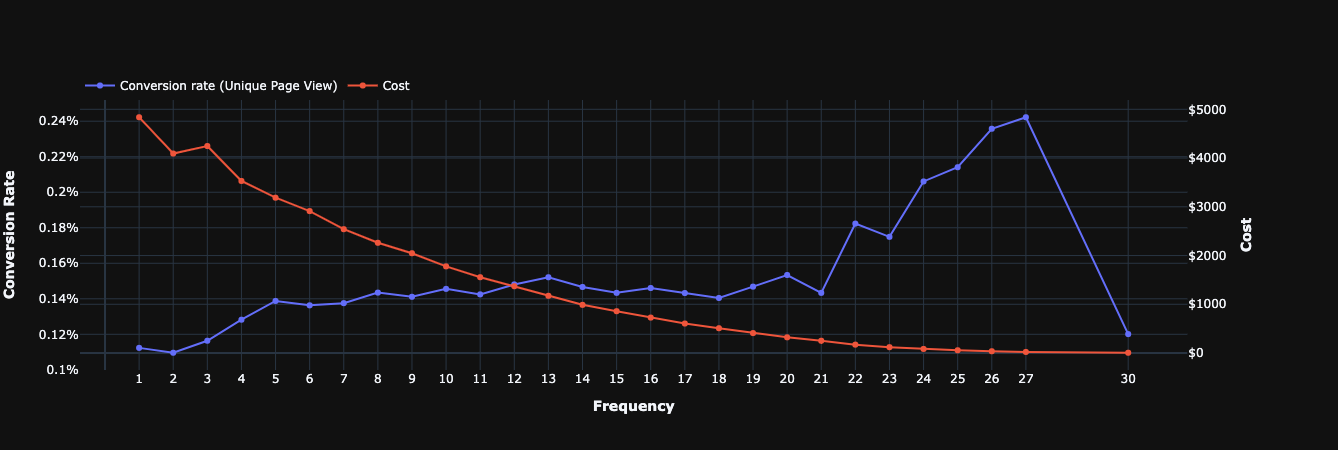

In [70]:
costs = df[['frequency', 'dv360_youtube_media_cost', 'conversion_rate']]

#fig = go.Figure()
fig = make_subplots(specs=[[{"secondary_y": True}]])


fig.add_trace(go.Scatter(x=costs.frequency, 
                         y=costs.conversion_rate,
                         mode='lines+markers',
                         name='Conversion rate (Unique Page View)'), secondary_y=False)

fig.add_trace(go.Scatter(x=costs.frequency, 
                         y=costs.dv360_youtube_media_cost,
                         mode='lines+markers',
                         name='Cost'), secondary_y=True)

fig.update_layout(
    #title='<b>Conversion rate and cost vs Frequency',
    template="plotly_dark",
    xaxis = dict(
        tickmode = 'array',
        tickvals = df["frequency"],
        ticktext = df["frequency"]),
    xaxis_title="<b>Frequency</b>",
    yaxis_title="<b>Conversion rate</b>",
)

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1,
    xanchor="left",
    x=0
))

# Set y-axes titles
fig.update_yaxes(title_text="<b>Conversion Rate</b>", ticksuffix = "%", secondary_y=False)
fig.update_yaxes(title_text="<b>Cost</b>", tickprefix = "$", secondary_y=True)



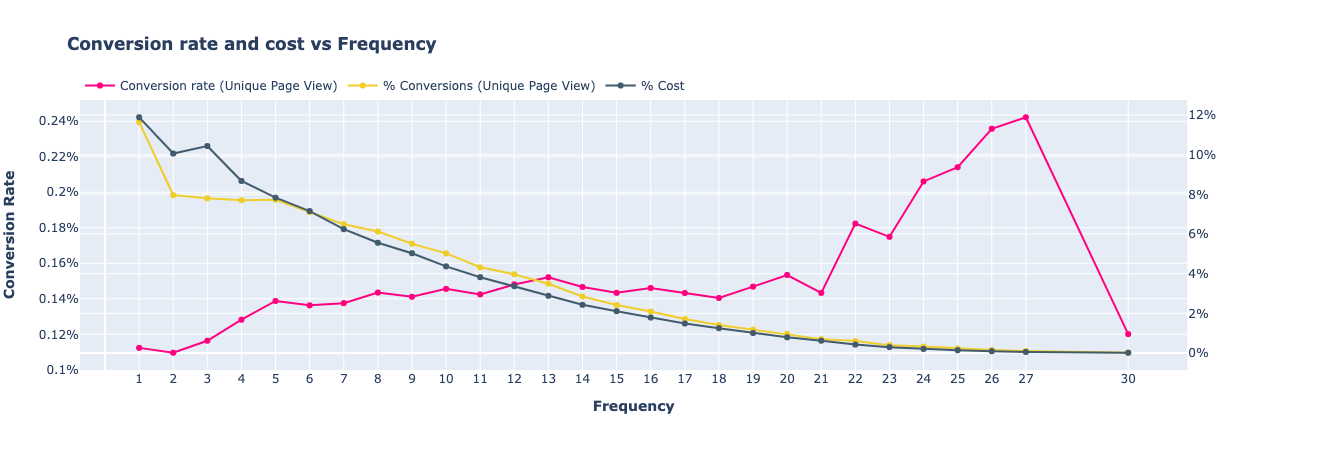

In [71]:
costs = df[['frequency', 'total_conversions', 'dv360_youtube_media_cost', 'conversion_rate']]

#fig = go.Figure()
fig = make_subplots(specs=[[{"secondary_y": True}]])


fig.add_trace(go.Scatter(x=costs.frequency, 
                         y=costs.conversion_rate,
                         mode='lines+markers',
                         name='Conversion rate (Unique Page View)', marker_color='#ff007f'), secondary_y=False)


fig.add_trace(go.Scatter(x=costs.frequency, 
                         y=costs.total_conversions/costs.total_conversions.sum()*100,
                         mode='lines+markers',
                         name='% Conversions (Unique Page View)', marker_color='#f0cd28'), secondary_y=True)

fig.add_trace(go.Scatter(x=costs.frequency, 
                         y=costs.dv360_youtube_media_cost/costs.dv360_youtube_media_cost.sum()*100,
                         mode='lines+markers',
                         name='% Cost', marker_color='#415a6c'), secondary_y=True)


fig.update_layout(
    title='<b>Conversion rate and cost vs Frequency',
    #template="plotly_dark",
    xaxis = dict(
        tickmode = 'array',
        tickvals = df["frequency"],
        ticktext = df["frequency"]),
    xaxis_title="<b>Frequency</b>",
    yaxis_title="<b>Conversion rate</b>",
)

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1,
    xanchor="left",
    x=0
))


# Set y-axes titles
fig.update_yaxes(title_text="<b>Conversion Rate</b>", ticksuffix = "%", secondary_y=False)
fig.update_yaxes(ticksuffix = "%", secondary_y=True)


### CPA


In [72]:
costs = df[['frequency', 'total_conversions', 'dv360_clicks_cost', 'dv360_youtube_media_cost', 'conversion_rate']].copy()
costs['CPA'] = costs.loc[:,'dv360_youtube_media_cost']/costs.loc[:,'total_conversions']
costs

frequency  total_conversions  dv360_clicks_cost  dv360_youtube_media_cost  \
2         1.0               3795            3102.64                   4836.83   
3         2.0               2594            2841.27                   4092.15   
4         3.0               2542            2679.61                   4246.14   
5         4.0               2512            2501.37                   3529.65   
6         5.0               2519            2305.65                   3186.67   
7         6.0               2316            2149.37                   2912.10   
8         7.0               2117            1946.61                   2540.47   
9         8.0               1997            1750.57                   2261.49   
10        9.0               1796            1595.19                   2047.31   
11       10.0               1637            1411.71                   1777.59   
12       11.0               1408            1242.21                   1555.08   
13       12.0               1294            1103.08                   1370.73   
14       13.0               1139             948.46                   1173.87   
15       14.0                929             804.30                    988.16   
16       15.0                789             704.46                    858.02   
17       16.0                682             600.05                    727.16   
18       17.0                558             503.87                    604.83   
19       18.0                459             427.76                    509.10   
20       19.0                383             341.58                    409.32   
21       20.0                315             268.22                    322.13   
22       21.0                228             210.35                    251.78   
23       22.0                197             139.18                    172.14   
24       23.0                129              94.84                    119.74   
25       24.0                105              64.50                     83.55   
26       25.0                 73              43.05                     56.45   
27       26.0                 51              27.60                     36.42   
28       27.0                 31              16.26                     21.87   
29       30.0                  4               4.22                      5.58   

    conversion_rate       CPA  
2           0.11236  1.274527  
3           0.10961  1.577544  
4           0.11638  1.670393  
5           0.12822  1.405115  
6           0.13877  1.265054  
7           0.13631  1.257383  
8           0.13755  1.200033  
9           0.14348  1.132444  
10          0.14113  1.139928  
11          0.14558  1.085883  
12          0.14248  1.104460  
13          0.14809  1.059297  
14          0.15212  1.030615  
15          0.14665  1.063681  
16          0.14334  1.087478  
17          0.14607  1.066217  
18          0.14324  1.083925  
19          0.14046  1.109150  
20          0.14684  1.068721  
21          0.15340  1.022635  
22          0.14333  1.104298  
23          0.18234  0.873807  
24          0.17489  0.928217  
25          0.20608  0.795714  
26          0.21408  0.773288  
27          0.23576  0.714118  
28          0.24223  0.705484  
29          0.12012  1.395000

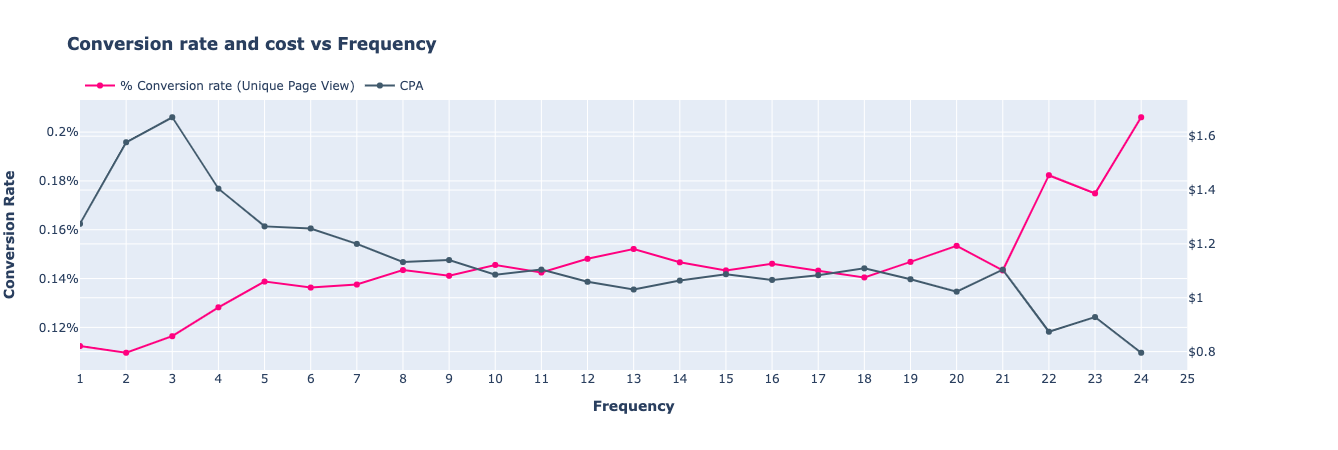

In [75]:
costs = df[['frequency', 'total_conversions', 'dv360_clicks_cost', 'dv360_youtube_media_cost', 'conversion_rate']].copy()
costs['CPA'] = costs.loc[:,'dv360_youtube_media_cost']/costs.loc[:,'total_conversions']
costs = costs.loc[0:25,:]
#fig = go.Figure()
fig = make_subplots(specs=[[{"secondary_y": True}]])


fig.add_trace(go.Scatter(x=costs.frequency, 
                         y=costs.conversion_rate,
                         mode='lines+markers',
                         name='% Conversion rate (Unique Page View)', marker_color='#ff007f'), secondary_y=False)


fig.add_trace(go.Scatter(x=costs.frequency, 
                         y=costs.CPA,
                         mode='lines+markers',
                         name='CPA', marker_color='#415a6c'), secondary_y=True)

# % Conversions (Buy Button)
#fig.add_trace(go.Scatter(x=costs.frequency, 
#                         y=costs.total_conversions/costs.total_conversions.sum()*100,
#                         mode='lines+markers',
#                         name='% Conversions (Buy Button)', marker_color='#f0cd28'), secondary_y=True)

# % Cost
#fig.add_trace(go.Scatter(x=costs.frequency, 
#                         y=costs.dv360_youtube_media_cost/costs.dv360_youtube_media_cost.sum()*100,
#                         mode='lines+markers',
#                         name='% Cost', marker_color='#415a6c'), secondary_y=True)



fig.update_layout(
    title='<b>Conversion rate and cost vs Frequency',
    #template="plotly_dark",
    xaxis = dict(
        tickmode = 'array',
        tickvals = df["frequency"],
        ticktext = df["frequency"]),
    xaxis_title="<b>Frequency</b>",
    yaxis_title="<b>Conversion rate</b>",
    xaxis_range=[1,25]
)

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1,
    xanchor="left",
    x=0
))


# Set y-axes titles
fig.update_yaxes(title_text="<b>Conversion Rate</b>", ticksuffix = "%", secondary_y=False)
fig.update_yaxes(tickprefix = "$", secondary_y=True)

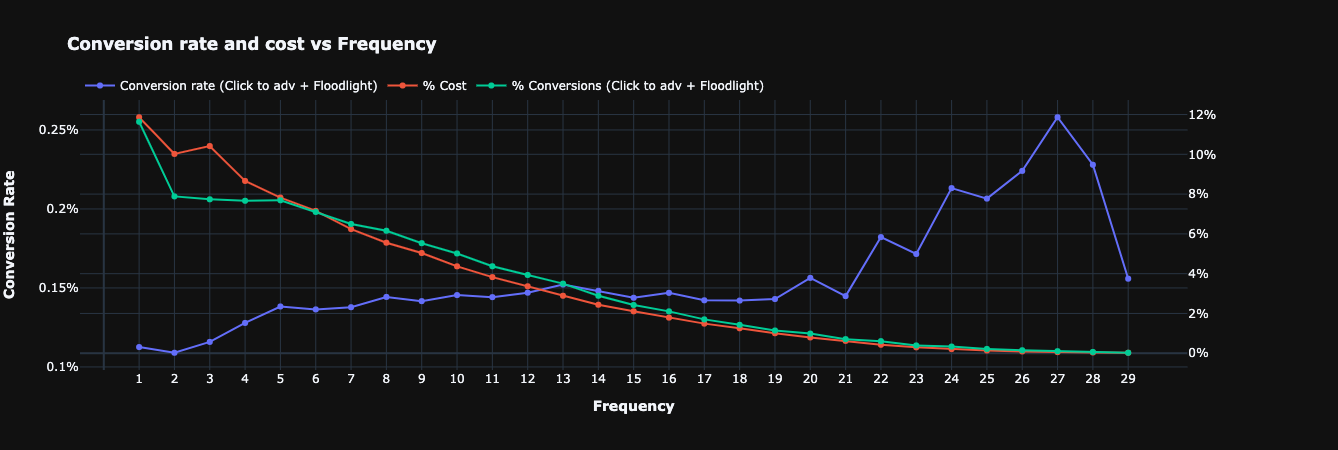

In [120]:
costs = df[['frequency', 'total_conversions', 'dv360_youtube_media_cost', 'conversion_rate']]

#fig = go.Figure()
fig = make_subplots(specs=[[{"secondary_y": True}]])


fig.add_trace(go.Scatter(x=costs.frequency, 
                         y=costs.conversion_rate,
                         mode='lines+markers',
                         name='Conversion rate (Click to adv + Floodlight)'), secondary_y=False)

fig.add_trace(go.Scatter(x=costs.frequency, 
                         y=costs.dv360_youtube_media_cost/costs.dv360_youtube_media_cost.sum()*100,
                         mode='lines+markers',
                         name='% Cost'), secondary_y=True)

fig.add_trace(go.Scatter(x=costs.frequency, 
                         y=costs.total_conversions/costs.total_conversions.sum()*100,
                         mode='lines+markers',
                         name='% Conversions (Click to adv + Floodlight)'), secondary_y=True)

fig.update_layout(
    title='<b>Conversion rate and cost vs Frequency',
    template="plotly_dark",
    xaxis = dict(
        tickmode = 'array',
        tickvals = df["frequency"],
        ticktext = df["frequency"]),
    xaxis_title="<b>Frequency</b>",
    yaxis_title="<b>Conversion rate</b>",
)

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1,
    xanchor="left",
    x=0
))


# Set y-axes titles
fig.update_yaxes(title_text="<b>Conversion Rate</b>", ticksuffix = "%", secondary_y=False)
fig.update_yaxes(ticksuffix = "%", secondary_y=True)


# Venn Diagram Funnel

In [15]:
query = '''
SELECT * 
FROM `rb-hygiene-markets-global-prod.adh_results_apac.rc_user_overlap_pageview_conversions_dv360youtube_1_20210712_20210822_2`
'''
user_overlap = client.query(query)
user_overlap= user_overlap.to_dataframe()
user_overlap.to_csv('user_overlap.csv', index=False)

#user_overlap = pd.read_csv("user_overlap.csv")

In [21]:
user_overlap

partner_id  advertiser_id  campaign_id  users_exlusive_know  \
0   599149418      603701472      6822204              2562547   

   users_exlusive_think  users_exlusive_do  users_know_think  users_know_do  \
0               1273598             910764           1282277         268323   

   users_think_do  users_know_think_do  ...  cost_users_know_think_do  \
0          422191               752466  ...              15429.170262   

   total_impressions  total_impressions2  total_impressions3  \
0           26946048            26946048            26946048   

   total_conversions  total_conversions_summing  total_cost_in_usd  \
0              32598                      32529       44460.777791   

   total_cost_in_usd_summing  reach_total_users  total_users_summing  
0               44451.694975            7505017              7472166  

[1 rows x 40 columns]

##### Users overlap percentage

In [22]:
user_overlap_perc = user_overlap[['users_exlusive_know', 'users_exlusive_think', 'users_exlusive_do', 'users_know_think', 'users_know_do', 'users_think_do', 'users_know_think_do', 'reach_total_users']]
user_overlap_perc = round(user_overlap_perc/ user_overlap_perc.reach_total_users[0]*100, 1)
user_overlap_perc

users_exlusive_know  users_exlusive_think  users_exlusive_do  \
0                 34.1                  17.0               12.1   

   users_know_think  users_know_do  users_think_do  users_know_think_do  \
0              17.1            3.6             5.6                 10.0   

   reach_total_users  
0              100.0

##### Conversion rate CVR = (number of conversions / impressions) x 100


In [23]:
cvr_df = pd.DataFrame()
cvr_df['cvr_know'] = round(user_overlap.conv_users_exlusive_know/user_overlap.imp_users_exlusive_know.values*100, 4)
cvr_df['cvr_think'] = round(user_overlap.conv_users_exlusive_think/user_overlap.imp_users_exlusive_think.values*100, 4)
cvr_df['cvr_do'] = round(user_overlap.conv_users_exlusive_do/user_overlap.imp_users_exlusive_do.values*100, 4)
cvr_df['cvr_know_think'] = round(user_overlap.conv_users_know_think/user_overlap.imp_users_know_think.values*100, 4)
cvr_df['cvr_know_do'] = round(user_overlap.conv_users_know_do/user_overlap.imp_users_know_do.values*100, 4)
cvr_df['cvr_think_do'] = round(user_overlap.conv_users_think_do/user_overlap.imp_users_think_do.values*100, 4)
cvr_df['cvr_know_think_do'] = round(user_overlap.conv_users_know_think_do/user_overlap.imp_users_know_think_do.values*100, 4)
cvr_df['overall'] = round(user_overlap.total_conversions/user_overlap.total_impressions.values*100, 4)
cvr_df

cvr_know  cvr_think  cvr_do  cvr_know_think  cvr_know_do  cvr_think_do  \
0    0.0717     0.0815  0.1787          0.0364       0.3057        0.2764   

   cvr_know_think_do  overall  
0             0.1523    0.121

##### Cost per Acquisiton = (cost / conversion) x 100


In [24]:
user_overlap.cost_users_exlusive_know

0    5021.628777
Name: cost_users_exlusive_know, dtype: float64

In [25]:
cpa_df = pd.DataFrame()
cpa_df['cpa_know'] = round(user_overlap.cost_users_exlusive_know/user_overlap.conv_users_exlusive_know.values, 2)
cpa_df['cpa_think'] = round(user_overlap.cost_users_exlusive_think/user_overlap.conv_users_exlusive_think.values, 2)
cpa_df['cpa_do'] = round(user_overlap.cost_users_exlusive_do/user_overlap.conv_users_exlusive_do.values, 2)
cpa_df['cpa_know_think'] = round(user_overlap.cost_users_know_think/user_overlap.conv_users_know_think.values, 2)
cpa_df['cpa_know_do'] = round(user_overlap.cost_users_know_do/user_overlap.conv_users_know_do.values, 2)
cpa_df['cpa_think_do'] = round(user_overlap.cost_users_think_do/user_overlap.conv_users_think_do.values, 2)
cpa_df['cpa_know_think_do'] = round(user_overlap.cost_users_know_think_do/user_overlap.conv_users_know_think_do.values, 2)
cpa_df['overall'] = round(user_overlap.total_cost_in_usd/user_overlap.total_conversions.values, 2)
cpa_df

cpa_know  cpa_think  cpa_do  cpa_know_think  cpa_know_do  cpa_think_do  \
0       1.8        1.4    1.93            4.24         0.74          0.63   

   cpa_know_think_do  overall  
0               1.09     1.36

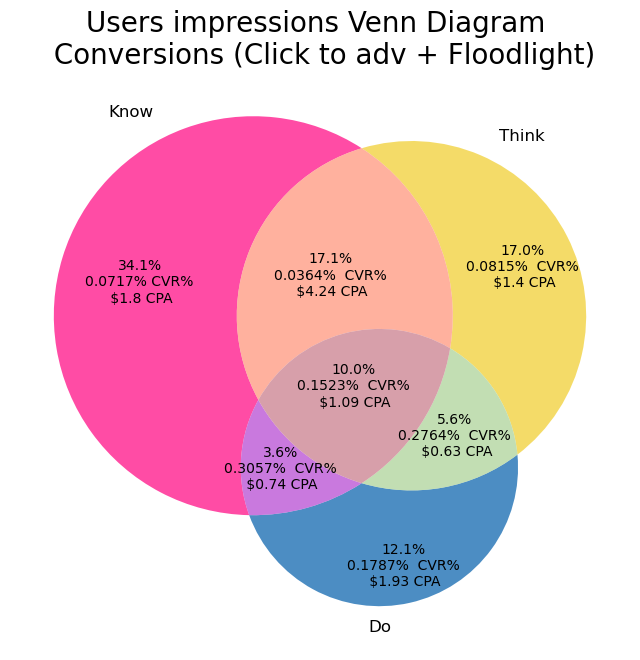

In [26]:
#help: subsets = (Abc, 
#                 aBc, 
#                 ABc, 
#                 abC, 
#                 AbC, 
#                 aBC, 
#                 ABC)
# A = know, B=think, C=do
plt.style.use(['default'])
plt.figure(figsize=(8,8), edgecolor="white")
v = venn3(subsets = (user_overlap_perc.users_exlusive_know[0], 
                 user_overlap_perc.users_exlusive_think[0], 
                 user_overlap_perc.users_know_think[0], 
                 user_overlap_perc.users_exlusive_do[0], 
                 user_overlap_perc.users_know_do[0], 
                 user_overlap_perc.users_think_do[0], 
                 user_overlap_perc.users_know_think_do[0]), set_labels = ('Know', 'Think', 'Do'), set_colors=('#ff007f', '#f0cd28', '#005daa'), alpha = 0.7)

#marker_color='#ff007f' marker_color='#f0cd28' marker_color='#005daa'

plt.title("Users impressions Venn Diagram \n Conversions (Click to adv + Floodlight)", fontsize=20)

# setting color of id 11 to purple
#v.get_patch_by_id('11').set_color('purple')
#setting label of id 10 to New Text
v.get_label_by_id('100').set_text(str(user_overlap_perc.users_exlusive_know[0])  + '%\n' + str(cvr_df.cvr_know[0]) + '% CVR' + '%\n $' + str(cpa_df.cpa_know[0]) + ' CPA')
v.get_label_by_id('010').set_text(str(user_overlap_perc.users_exlusive_think[0]) + '%\n' + str(cvr_df.cvr_think[0]) + '%  CVR' + '%\n $' + str(cpa_df.cpa_think[0]) + ' CPA' )
v.get_label_by_id('110').set_text(str(user_overlap_perc.users_know_think[0])     + '%\n' + str(cvr_df.cvr_know_think[0]) + '%  CVR' + '%\n $' + str(cpa_df.cpa_know_think[0]) + ' CPA' )
v.get_label_by_id('001').set_text(str(user_overlap_perc.users_exlusive_do[0])    + '%\n' + str(cvr_df.cvr_do[0]) + '%  CVR' + '%\n $' + str(cpa_df.cpa_do[0]) + ' CPA' )
v.get_label_by_id('101').set_text(str(user_overlap_perc.users_know_do[0])        + '%\n' + str(cvr_df.cvr_know_do[0]) + '%  CVR' + '%\n $' + str(cpa_df.cpa_know_do[0]) + ' CPA')
v.get_label_by_id('011').set_text(str(user_overlap_perc.users_think_do[0])       + '%\n' + str(cvr_df.cvr_think_do[0]) + '%  CVR' + '%\n $' + str(cpa_df.cpa_think_do[0]) + ' CPA')
v.get_label_by_id('111').set_text(str(user_overlap_perc.users_know_think_do[0])  + '%\n' + str(cvr_df.cvr_know_think_do[0]) + '%  CVR' + '%\n $' + str(cpa_df.cpa_know_think_do[0]) + ' CPA')

plt.show()

# Conversion: click floodlight landing page + click_to_advertiser_site (ONLY CONVERTED USERS)

In [87]:
client = bigquery.Client()

In [88]:
client

In [89]:
query = '''
SELECT * 
FROM `rb-hygiene-markets-global-prod.adh_results_apac.rc_freq_imp_conv_filteringconvertedusers_dv360youtube_1_20210712_20210822_1`
'''
df = client.query(query)
df= df.to_dataframe()
df.to_csv('df.csv', index=False)

#df = pd.read_csv("df.csv")

In [90]:
summary = df[['reach', 'total_impressions','total_clicks','total_conversions','dv360_youtube_media_cost']].sum()
summary

reach                         32822.00
total_impressions           2460380.00
total_clicks                1370488.00
total_conversions             47256.00
dv360_youtube_media_cost       4074.64
dtype: float64

In [91]:
df = df[df.frequency > 0]
df['cumsum_reach'] = df['reach'].cumsum()
df['cumsum_imp'] = df['total_impressions'].cumsum()
df['cumsum_conv'] = df['total_conversions'].cumsum()
df['cumsum_cost'] = df['dv360_youtube_media_cost'].cumsum()
df['cumsum_imp_cost'] = df['dv360_imp_cost'].cumsum()
df['cumsum_click_cost'] = df['dv360_clicks_cost'].cumsum()
df

partner_id  advertiser_id  campaign_id  frequency  reach  \
2   599149418.0    603701472.0    6822204.0        1.0   3809   
3   599149418.0    603701472.0    6822204.0        2.0   2576   
4   599149418.0    603701472.0    6822204.0        3.0   2533   
5   599149418.0    603701472.0    6822204.0        4.0   2514   
6   599149418.0    603701472.0    6822204.0        5.0   2511   
7   599149418.0    603701472.0    6822204.0        6.0   2330   
8   599149418.0    603701472.0    6822204.0        7.0   2126   
9   599149418.0    603701472.0    6822204.0        8.0   2015   
10  599149418.0    603701472.0    6822204.0        9.0   1813   
11  599149418.0    603701472.0    6822204.0       10.0   1642   
12  599149418.0    603701472.0    6822204.0       11.0   1432   
13  599149418.0    603701472.0    6822204.0       12.0   1291   
14  599149418.0    603701472.0    6822204.0       13.0   1145   
15  599149418.0    603701472.0    6822204.0       14.0    950   
16  599149418.0    603701472.0    6822204.0       15.0    794   
17  599149418.0    603701472.0    6822204.0       16.0    689   
18  599149418.0    603701472.0    6822204.0       17.0    556   
19  599149418.0    603701472.0    6822204.0       18.0    472   
20  599149418.0    603701472.0    6822204.0       19.0    371   
21  599149418.0    603701472.0    6822204.0       20.0    323   
22  599149418.0    603701472.0    6822204.0       21.0    232   
23  599149418.0    603701472.0    6822204.0       22.0    200   
24  599149418.0    603701472.0    6822204.0       23.0    129   
25  599149418.0    603701472.0    6822204.0       24.0    110   
26  599149418.0    603701472.0    6822204.0       25.0     72   

    total_impressions  total_clicks  total_conversions  total_imp_know  \
2                3809          4243               5050             927   
3                5152          4249               3585            1413   
4                7599          6192               3581            1998   
5               10056          7943               3479            2826   
6               12555          9484               3522            3867   
7               13980         10172               3266            4772   
8               14882         10663               3097            5482   
9               16120         11380               2811            6394   
10              16317         11326               2566            6704   
11              16420         11152               2478            7111   
12              15752         10624               2086            6871   
13              15492         10771               1938            6869   
14              14885         10217               1688            6693   
15              13300          9192               1403            5915   
16              11910          8230               1319            5306   
17              11024          7500                984            4757   
18               9452          6380                789            3945   
19               8496          5716                701            3546   
20               7049          4765                544            2909   
21               6460          4330                463            2654   
22               4872          3394                327            1977   
23               4400          2943                281            1746   
24               2967          2054                168            1157   
25               2640          1809                175            1003   
26               1800          1282                 97             673   

    total_imp_think  ...  conversion_rate  dv360_youtube_media_cost  \
2              1713  ...        132.58073                     15.57   
3              2067  ...         69.58463                     17.06   
4              2347  ...         47.12462                     26.79   
5              2777  ...         34.59626                     25.89   
6              3167  ...         2

### Funnel impressions

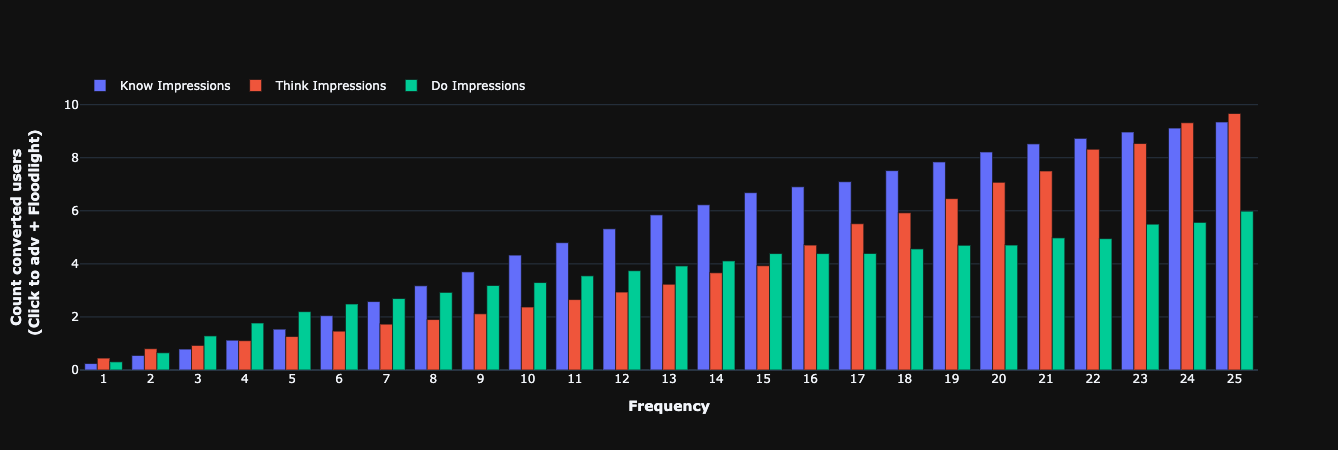

In [92]:
fig = go.Figure()

fig.add_trace(go.Bar(x=df.frequency,
                     y=df.total_imp_know/df.total_impressions*df.frequency,
                     name="Know Impressions"))

fig.add_trace(go.Bar(x=df.frequency,
                     y=df.total_imp_think/df.total_impressions*df.frequency,
                     name="Think Impressions"))

fig.add_trace(go.Bar(x=df.frequency,
                     y=df.total_imp_do/df.total_impressions*df.frequency,
                     name="Do Impressions"))


fig.update_layout(
    #title='<b>Reach & Impressions & Conversions - Buy </b>',
    template="plotly_dark",
    xaxis = dict(
        tickmode = 'array',
        tickvals = df["frequency"],
        ticktext = df["frequency"]),
    xaxis_title="<b>Frequency</b>",
)

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1,
    xanchor="left",
    x=0
))

# Set y-axes titles
fig.update_yaxes(title_text="<b>Count converted users <br> (Click to adv + Floodlight)</b>")

# Venn Diagram Funnel (CHANGE IN ORDER TO GET CVR WIHT (Click to adv + Floodlight)
CHECK THE MATH

In [93]:
query = '''
SELECT * 
FROM `rb-hygiene-markets-global-prod.adh_results_apac.rc_user_overlap_dv360youtube_3_20210712_20210822_1`
'''
user_overlap = client.query(query)
user_overlap= user_overlap.to_dataframe()
user_overlap.to_csv('user_overlap.csv', index=False)

#user_overlap = pd.read_csv("user_overlap.csv")

In [94]:
user_overlap

partner_id  advertiser_id  campaign_id  users_exlusive_know  \
0   599149418      603701472      6822204              2563273   

   users_exlusive_think  users_exlusive_do  users_know_think  users_know_do  \
0               1268826             937389           1277756         274932   

   users_think_do  users_know_think_do  ...  conv_users_know_think  \
0          428853               764142  ...                      2   

   conv_users_know_do  conv_users_think_do  conv_users_know_think_do  \
0                  31                   79                       162   

   total_impressions  total_impressions2  total_conversions  \
0           26946048            26946048                364   

   total_conversions_summing  reach_total_users  total_users_summing  
0                        364            7515171              7515171  

[1 rows x 23 columns]

##### Users overlap percentage

In [95]:
user_overlap_perc = user_overlap[['users_exlusive_know', 'users_exlusive_think', 'users_exlusive_do', 'users_know_think', 'users_know_do', 'users_think_do', 'users_know_think_do', 'reach_total_users']]
user_overlap_perc = round(user_overlap_perc/ user_overlap_perc.reach_total_users[0]*100, 1)
user_overlap_perc

users_exlusive_know  users_exlusive_think  users_exlusive_do  \
0                 34.1                  16.9               12.5   

   users_know_think  users_know_do  users_think_do  users_know_think_do  \
0              17.0            3.7             5.7                 10.2   

   reach_total_users  
0              100.0

##### Conversion rate CVR = (number of conversions / impressions) x 100
I'm dividing using users, not impressions. ¡¡¡CHECK!!!

In [96]:
cvr_df = pd.DataFrame()
cvr_df['cvr_know'] = round(user_overlap.conv_users_exlusive_know/user_overlap.users_exlusive_know.values*100, 4)
cvr_df['cvr_think'] = round(user_overlap.conv_users_exlusive_think/user_overlap.users_exlusive_think.values*100, 4)
cvr_df['cvr_do'] = round(user_overlap.conv_users_exlusive_do/user_overlap.users_exlusive_do.values*100, 4)
cvr_df['cvr_know_think'] = round(user_overlap.conv_users_know_think/user_overlap.users_know_think.values*100, 4)
cvr_df['cvr_know_do'] = round(user_overlap.conv_users_know_do/user_overlap.users_know_do.values*100, 4)
cvr_df['cvr_think_do'] = round(user_overlap.conv_users_think_do/user_overlap.users_think_do.values*100, 4)
cvr_df['cvr_know_think_do'] = round(user_overlap.conv_users_know_think_do/user_overlap.users_know_think_do.values*100, 4)
cvr_df['overall'] = round(user_overlap.total_conversions/user_overlap.reach_total_users.values*100, 4)
cvr_df

cvr_know  cvr_think  cvr_do  cvr_know_think  cvr_know_do  cvr_think_do  \
0       0.0     0.0001  0.0094          0.0002       0.0113        0.0184   

   cvr_know_think_do  overall  
0             0.0212   0.0048

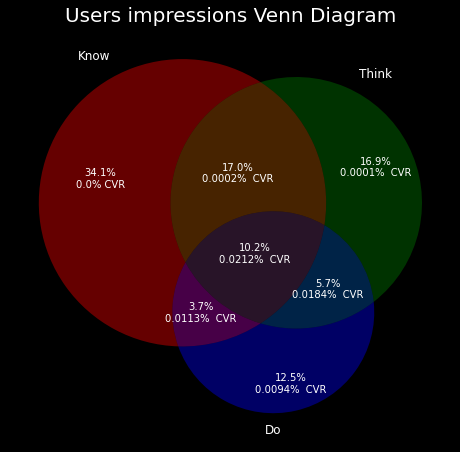

In [97]:
#help: subsets = (Abc, 
#                 aBc, 
#                 ABc, 
#                 abC, 
#                 AbC, 
#                 aBC, 
#                 ABC)
# A = know, B=think, C=do
plt.style.use(['dark_background'])
plt.figure(figsize=(8,8), edgecolor="white")
v = venn3(subsets = (user_overlap_perc.users_exlusive_know[0], 
                 user_overlap_perc.users_exlusive_think[0], 
                 user_overlap_perc.users_know_think[0], 
                 user_overlap_perc.users_exlusive_do[0], 
                 user_overlap_perc.users_know_do[0], 
                 user_overlap_perc.users_think_do[0], 
                 user_overlap_perc.users_know_think_do[0]), set_labels = ('Know', 'Think', 'Do'))

plt.title("Users impressions Venn Diagram", fontsize=20)

# setting color of id 11 to purple
#v.get_patch_by_id('11').set_color('purple')
#setting label of id 10 to New Text
v.get_label_by_id('100').set_text(str(user_overlap_perc.users_exlusive_know[0])  + '%\n' + str(cvr_df.cvr_know[0]) + '% CVR' )
v.get_label_by_id('010').set_text(str(user_overlap_perc.users_exlusive_think[0]) + '%\n' + str(cvr_df.cvr_think[0]) + '%  CVR' )
v.get_label_by_id('110').set_text(str(user_overlap_perc.users_know_think[0])     + '%\n' + str(cvr_df.cvr_know_think[0]) + '%  CVR' )
v.get_label_by_id('001').set_text(str(user_overlap_perc.users_exlusive_do[0])    + '%\n' + str(cvr_df.cvr_do[0]) + '%  CVR' )
v.get_label_by_id('101').set_text(str(user_overlap_perc.users_know_do[0])        + '%\n' + str(cvr_df.cvr_know_do[0]) + '%  CVR' )
v.get_label_by_id('011').set_text(str(user_overlap_perc.users_think_do[0])       + '%\n' + str(cvr_df.cvr_think_do[0]) + '%  CVR' )
v.get_label_by_id('111').set_text(str(user_overlap_perc.users_know_think_do[0])  + '%\n' + str(cvr_df.cvr_know_think_do[0]) + '%  CVR' )

plt.show()

In [222]:
df = df[df.frequency > 0]
df['cumsum_reach'] = df['reach'].cumsum()
df['cumsum_imp'] = df['total_impressions'].cumsum()
df['cumsum_conv'] = df['total_conversions'].cumsum()
df['cumsum_cost'] = df['dv360_youtube_media_cost'].cumsum()
df['cumsum_imp_cost'] = df['dv360_imp_cost'].cumsum()
df['cumsum_click_cost'] = df['dv360_clicks_cost'].cumsum()
df

partner_id  advertiser_id  campaign_id  frequency    reach  \
2   599149418.0    603701472.0    6822204.0        1.0  3385025   
3   599149418.0    603701472.0    6822204.0        2.0  1184466   
4   599149418.0    603701472.0    6822204.0        3.0   729399   
5   599149418.0    603701472.0    6822204.0        4.0   490947   
6   599149418.0    603701472.0    6822204.0        5.0   364344   
7   599149418.0    603701472.0    6822204.0        6.0   284474   
8   599149418.0    603701472.0    6822204.0        7.0   220732   
9   599149418.0    603701472.0    6822204.0        8.0   174774   
10  599149418.0    603701472.0    6822204.0        9.0   142339   
11  599149418.0    603701472.0    6822204.0       10.0   113059   
12  599149418.0    603701472.0    6822204.0       11.0    90357   
13  599149418.0    603701472.0    6822204.0       12.0    73192   
14  599149418.0    603701472.0    6822204.0       13.0    57988   
15  599149418.0    603701472.0    6822204.0       14.0    45707   
16  599149418.0    603701472.0    6822204.0       15.0    36887   
17  599149418.0    603701472.0    6822204.0       16.0    29379   
18  599149418.0    603701472.0    6822204.0       17.0    23079   
19  599149418.0    603701472.0    6822204.0       18.0    18310   
20  599149418.0    603701472.0    6822204.0       19.0    13806   
21  599149418.0    603701472.0    6822204.0       20.0    10368   
22  599149418.0    603701472.0    6822204.0       21.0     7630   
23  599149418.0    603701472.0    6822204.0       22.0     5012   
24  599149418.0    603701472.0    6822204.0       23.0     3240   
25  599149418.0    603701472.0    6822204.0       24.0     2170   
26  599149418.0    603701472.0    6822204.0       25.0     1386   

    total_impressions  total_clicks  total_conversions  total_imp_know  \
2             3385025       1328024               5048          836739   
3             2368932       1239492               3587          769339   
4             2188197       1286889               3578          778792   
5             1963788       1187432               3481          776161   
6             1821720       1110628               3521          768530   
7             1706844       1024882               3272          756813   
8             1545124        929273               3095          717435   
9             1398192        842808               2816          664650   
10            1281051        772830               2562          617671   
11            1130590        684762               2489          548088   
12             993927        602936               2076          481262   
13             878304        534962               1941          424002   
14             753844        459632               1694          360058   
15             639898        390719               1379          301947   
16             553305        337097               1308          257096   
17             470064        287619               1025          214658   
18             392343        240796                789          176657   
19             329580        203405                707          146495   
20             262314        164174                545          114505   
21             207360        132195                460           89111   
22             160230        103546                329           67715   
23             110264         72756                280           45573   
24              74520         50756                171           30096   
25              52080         36315                174           20553   
26              34650         24680                 99           13398   

    total_imp_think  ...  conversion_rate  dv360_youtube_media_cost  \
2           1863359  ...          0.14913                   4847.98   
3           1163658  ...          0.15142                   4093.39   
4            926186  ...          0.16351                   4258.51   
5            779039  ...          0.17726            

### Bar plot with count values

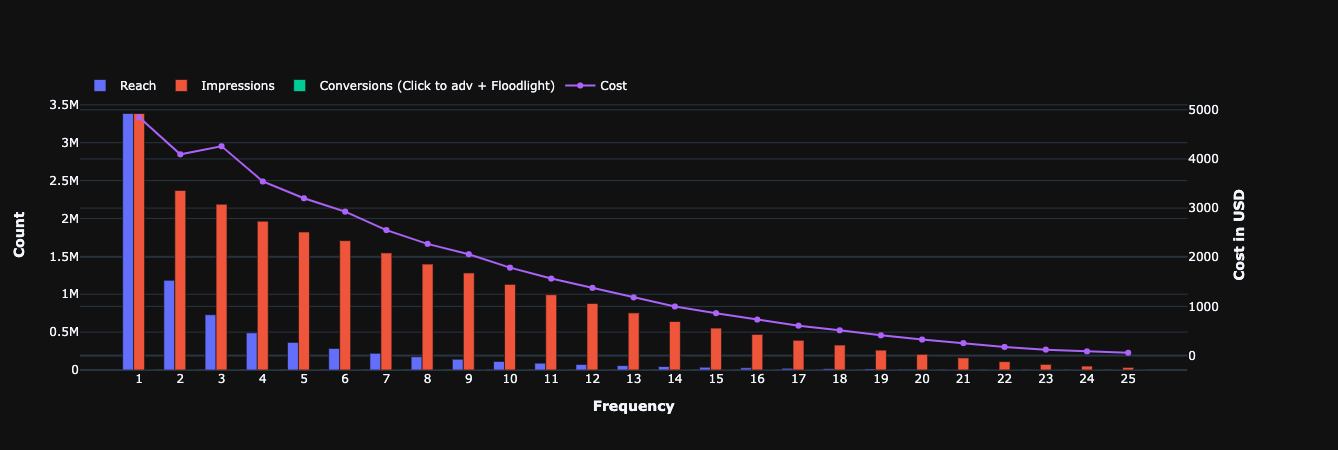

In [223]:
#fig = go.Figure()
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Bar(x=df.frequency,
                     y=df["reach"],
                     name="Reach"), secondary_y=False,)

fig.add_trace(go.Bar(x=df.frequency,
                     y=df["total_impressions"],
                     name="Impressions"), secondary_y=False,)

fig.add_trace(go.Bar(x=df.frequency,
                     y=df["total_conversions"],
                     name="Conversions (Click to adv + Floodlight)"), secondary_y=False,)

fig.add_trace(go.Scatter(x=df.frequency, y=df.dv360_youtube_media_cost,
                    mode='lines+markers',
                    name='Cost'), secondary_y=True,)


fig.update_layout(
    #title='<b>Reach & Impressions & Conversions - Buy </b>',
    template="plotly_dark",
    xaxis = dict(
        tickmode = 'array',
        tickvals = df["frequency"],
        ticktext = df["frequency"]),
    xaxis_title="<b>Frequency</b>",
)

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1,
    xanchor="left",
    x=0
))

# Set y-axes titles
fig.update_yaxes(title_text="<b>Count</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>Cost in USD</b>", secondary_y=True)

### Bar plot with cumulative values

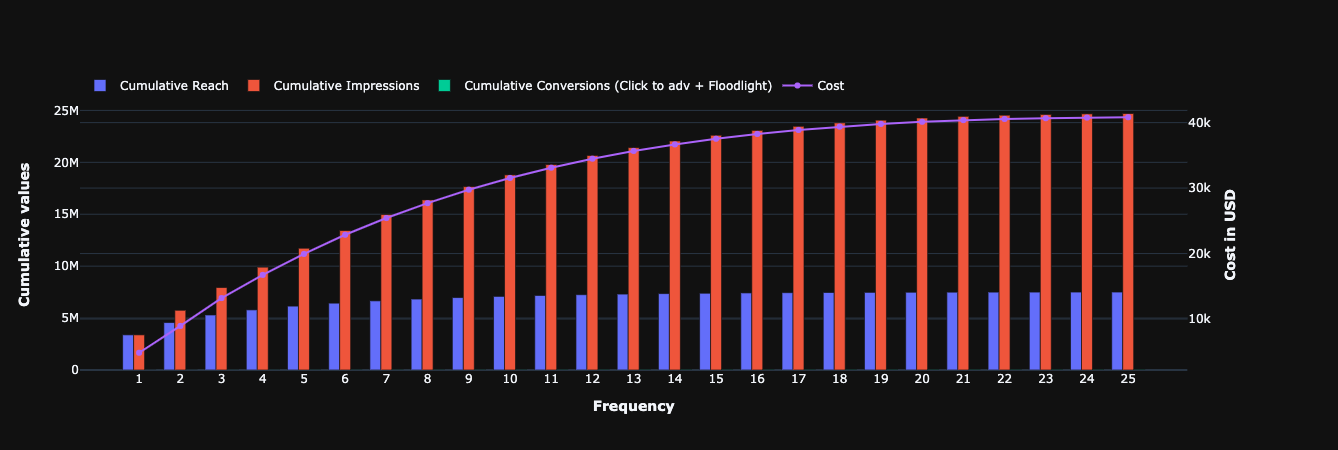

In [224]:
#fig = go.Figure()
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Bar(x=df.frequency,
                     y=df["cumsum_reach"],
                     name="Cumulative Reach"), secondary_y=False,)

fig.add_trace(go.Bar(x=df.frequency,
                     y=df["cumsum_imp"],
                     name="Cumulative Impressions"), secondary_y=False,)

fig.add_trace(go.Bar(x=df.frequency,
                     y=df["cumsum_conv"],
                     name="Cumulative Conversions (Click to adv + Floodlight)"), secondary_y=False,)

fig.add_trace(go.Scatter(x=df.frequency, y=df.cumsum_cost,
                    mode='lines+markers',
                    name='Cost'), secondary_y=True,)


fig.update_layout(
    #title='<b>Bar plot with cumulative values</b>',
    template="plotly_dark",
    xaxis = dict(
        tickmode = 'array',
        tickvals = df["frequency"],
        ticktext = df["frequency"]),
    xaxis_title="<b>Frequency</b>",
)

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1,
    xanchor="left",
    x=0
))

# Set y-axes titles
fig.update_yaxes(title_text="<b>Cumulative values</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>Cost in USD</b>", secondary_y=True)

### Bar plot with percentage count values

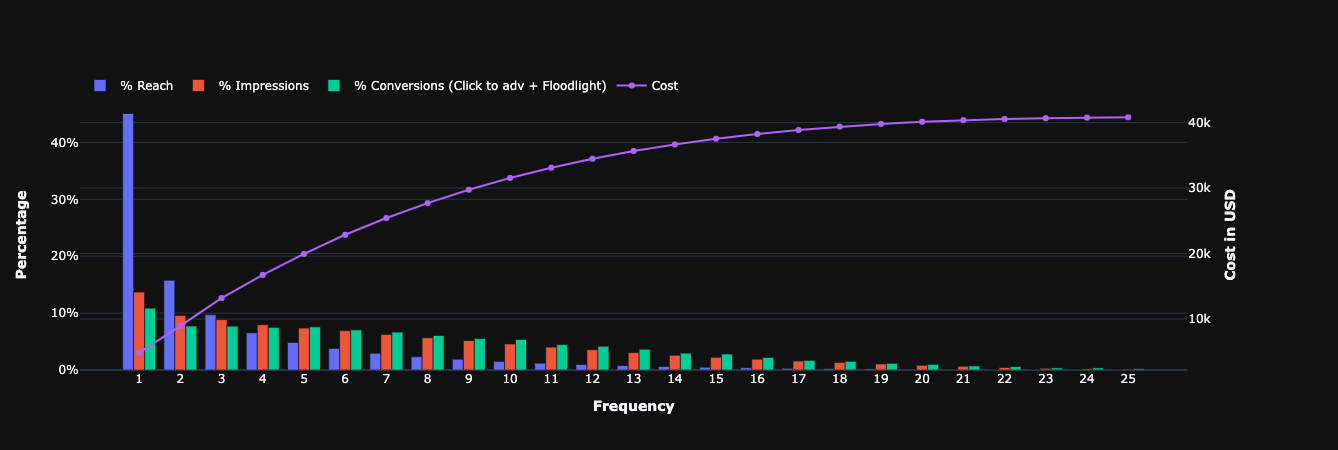

In [225]:
#fig = go.Figure()
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Bar(x=df.frequency,
                     y=df["reach"]/df["cumsum_reach"].max()*100,
                     name="% Reach"), secondary_y=False,)

fig.add_trace(go.Bar(x=df.frequency,
                     y=df["total_impressions"]/df["cumsum_imp"].max()*100,
                     name="% Impressions"), secondary_y=False,)

fig.add_trace(go.Bar(x=df.frequency,
                     y=df["total_conversions"]/df["cumsum_conv"].max()*100,
                     name="% Conversions (Click to adv + Floodlight)"), secondary_y=False,)

fig.add_trace(go.Scatter(x=df.frequency, 
                         y=df.cumsum_cost,
                         mode='lines+markers',
                        name='Cost'), secondary_y=True,)


fig.update_layout(
    #title='<b>Bar plot with percentage count values</b>',
    template="plotly_dark",
    xaxis = dict(
        tickmode = 'array',
        tickvals = df["frequency"],
        ticktext = df["frequency"]),
    xaxis_title="<b>Frequency</b>",
)


fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1,
    xanchor="left",
    x=0
))

# Set y-axes titles
fig.update_yaxes(title_text="<b>Percentage</b>", ticksuffix = "%", secondary_y=False)
fig.update_yaxes(title_text="<b>Cost in USD</b>", secondary_y=True)

### Bar plot with cumulative percentages

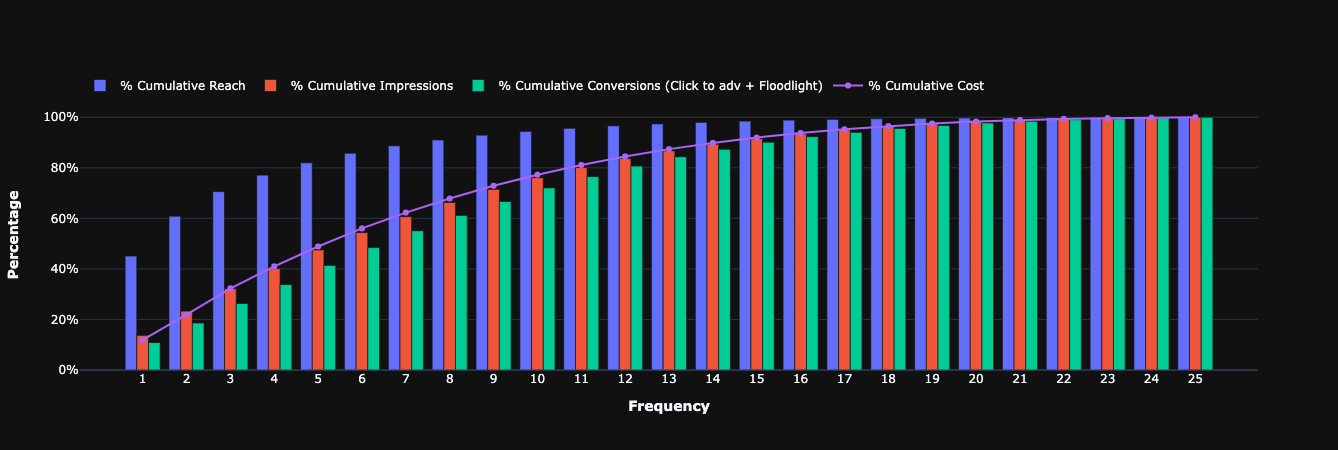

In [226]:
fig = go.Figure()


fig.add_trace(go.Bar(x=df.frequency,
                     y=df["cumsum_reach"]/df["cumsum_reach"].max()*100,
                     name="% Cumulative Reach"))

fig.add_trace(go.Bar(x=df.frequency,
                     y=df["cumsum_imp"]/df["cumsum_imp"].max()*100,
                     name="% Cumulative Impressions"))

fig.add_trace(go.Bar(x=df.frequency,
                     y=df["cumsum_conv"]/df["cumsum_conv"].max()*100,
                     name="% Cumulative Conversions (Click to adv + Floodlight)"))

fig.add_trace(go.Scatter(x=df.frequency, 
                         y=df.cumsum_cost/df.cumsum_cost.max()*100,
                         mode='lines+markers',
                         name='% Cumulative Cost'))


fig.update_layout(
    #title='<b>Bar plot with percentage values</b>',
    template="plotly_dark",
    xaxis = dict(
        tickmode = 'array',
        tickvals = df["frequency"],
        ticktext = df["frequency"]),
    xaxis_title="<b>Frequency</b>",
)

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1,
    xanchor="left",
    x=0
))

# Set y-axes titles
fig.update_yaxes(title_text="<b>Percentage</b>", ticksuffix = "%")


#### Conversion rate vs frequency (conversions/impressions)


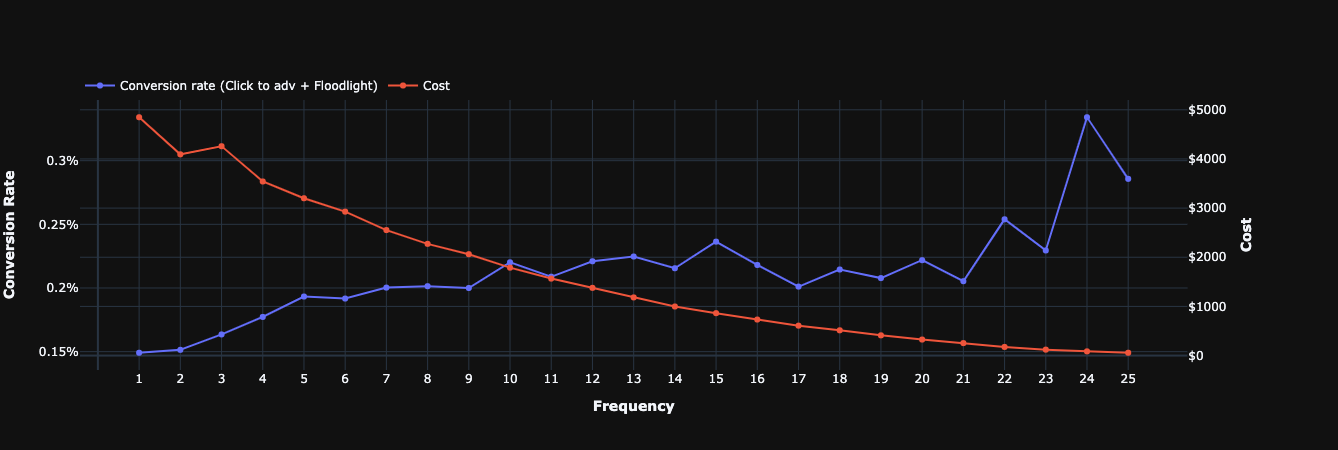

In [227]:
costs = df[['frequency', 'dv360_youtube_media_cost', 'conversion_rate']]

#fig = go.Figure()
fig = make_subplots(specs=[[{"secondary_y": True}]])


fig.add_trace(go.Scatter(x=costs.frequency, 
                         y=costs.conversion_rate,
                         mode='lines+markers',
                         name='Conversion rate (Click to adv + Floodlight)'), secondary_y=False)

fig.add_trace(go.Scatter(x=costs.frequency, 
                         y=costs.dv360_youtube_media_cost,
                         mode='lines+markers',
                         name='Cost'), secondary_y=True)

fig.update_layout(
    #title='<b>Conversion rate and cost vs Frequency',
    template="plotly_dark",
    xaxis = dict(
        tickmode = 'array',
        tickvals = df["frequency"],
        ticktext = df["frequency"]),
    xaxis_title="<b>Frequency</b>",
    yaxis_title="<b>Conversion rate</b>",
)

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1,
    xanchor="left",
    x=0
))

# Set y-axes titles
fig.update_yaxes(title_text="<b>Conversion Rate</b>", ticksuffix = "%", secondary_y=False)
fig.update_yaxes(title_text="<b>Cost</b>", tickprefix = "$", secondary_y=True)



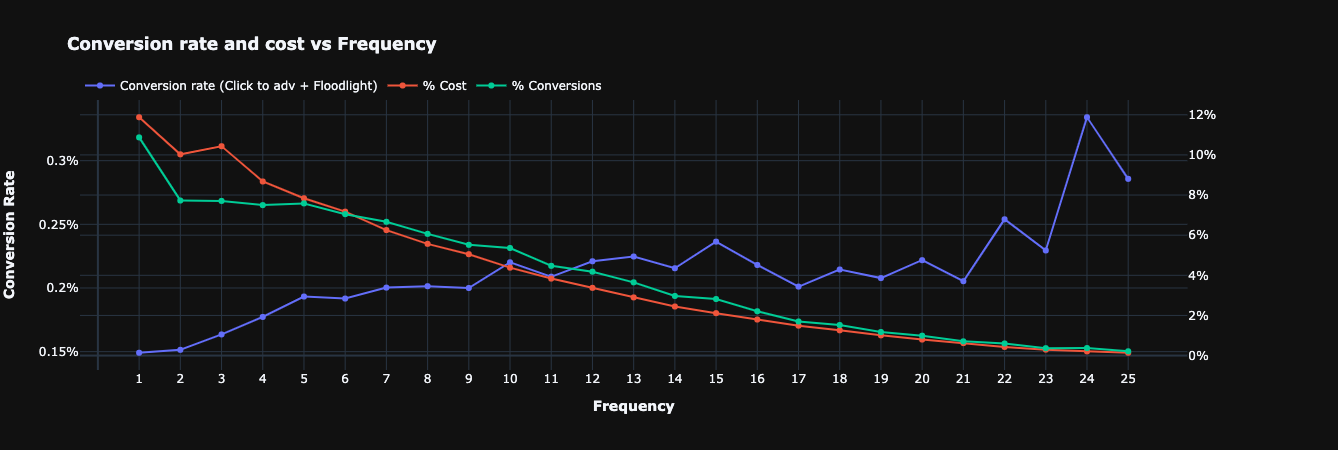

In [228]:
costs = df[['frequency', 'total_conversions', 'dv360_youtube_media_cost', 'conversion_rate']]

#fig = go.Figure()
fig = make_subplots(specs=[[{"secondary_y": True}]])


fig.add_trace(go.Scatter(x=costs.frequency, 
                         y=costs.conversion_rate,
                         mode='lines+markers',
                         name='Conversion rate (Click to adv + Floodlight)'), secondary_y=False)

fig.add_trace(go.Scatter(x=costs.frequency, 
                         y=costs.dv360_youtube_media_cost/costs.dv360_youtube_media_cost.sum()*100,
                         mode='lines+markers',
                         name='% Cost'), secondary_y=True)

fig.add_trace(go.Scatter(x=costs.frequency, 
                         y=costs.total_conversions/costs.total_conversions.sum()*100,
                         mode='lines+markers',
                         name='% Conversions'), secondary_y=True)

fig.update_layout(
    title='<b>Conversion rate and cost vs Frequency',
    template="plotly_dark",
    xaxis = dict(
        tickmode = 'array',
        tickvals = df["frequency"],
        ticktext = df["frequency"]),
    xaxis_title="<b>Frequency</b>",
    yaxis_title="<b>Conversion rate</b>",
)

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1,
    xanchor="left",
    x=0
))


# Set y-axes titles
fig.update_yaxes(title_text="<b>Conversion Rate</b>", ticksuffix = "%", secondary_y=False)
fig.update_yaxes(ticksuffix = "%", secondary_y=True)


### Cost per conversion


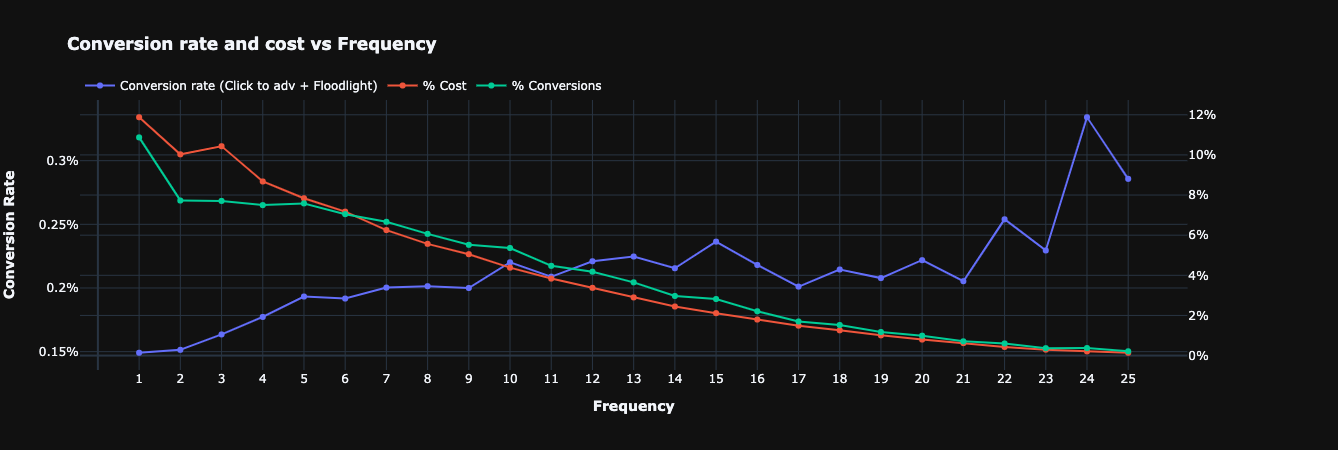

In [229]:
costs = df[['frequency', 'total_conversions', 'dv360_youtube_media_cost', 'conversion_rate']]

#fig = go.Figure()
fig = make_subplots(specs=[[{"secondary_y": True}]])


fig.add_trace(go.Scatter(x=costs.frequency, 
                         y=costs.conversion_rate,
                         mode='lines+markers',
                         name='Conversion rate (Click to adv + Floodlight)'), secondary_y=False)

fig.add_trace(go.Scatter(x=costs.frequency, 
                         y=costs.dv360_youtube_media_cost/costs.dv360_youtube_media_cost.sum()*100,
                         mode='lines+markers',
                         name='% Cost'), secondary_y=True)

fig.add_trace(go.Scatter(x=costs.frequency, 
                         y=costs.total_conversions/costs.total_conversions.sum()*100,
                         mode='lines+markers',
                         name='% Conversions'), secondary_y=True)

fig.update_layout(
    title='<b>Conversion rate and cost vs Frequency',
    template="plotly_dark",
    xaxis = dict(
        tickmode = 'array',
        tickvals = df["frequency"],
        ticktext = df["frequency"]),
    xaxis_title="<b>Frequency</b>",
    yaxis_title="<b>Conversion rate</b>",
)

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1,
    xanchor="left",
    x=0
))


# Set y-axes titles
fig.update_yaxes(title_text="<b>Conversion Rate</b>", ticksuffix = "%", secondary_y=False)
fig.update_yaxes(ticksuffix = "%", secondary_y=True)


# Venn Diagram Funnel --- FIRST ATTEMPTS --- THEY ARE INCOMPLETE OR WRONG

### Impressions Venn Diagram

In [182]:
query = '''
SELECT * 
FROM `rb-hygiene-markets-global-prod.adh_results_apac.rc_user_overlap_dv360youtube_1_20210712_20210822_1`
'''
user_overlap = client.query(query)
user_overlap= user_overlap.to_dataframe()
user_overlap.to_csv('user_overlap.csv', index=False)

#user_overlap = pd.read_csv("user_overlap.csv")

In [85]:
user_overlap

partner_id  advertiser_id  campaign_id  users_exlusive_know  \
0   599149418      603701472      6822204              2565307   

   users_exlusive_think  users_exlusive_do  users_know_think  users_know_do  \
0               1269607             942698           1278468         275941   

   users_think_do  users_know_think_do  total_impressions  total_impressions2  \
0          429918               765977           26946048            26946048   

   reach_total_users  total_users_summing  
0            7527916              7527916

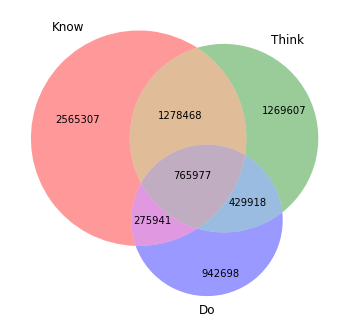

In [86]:
#help: subsets = (Abc, 
#                 aBc, 
#                 ABc, 
#                 abC, 
#                 AbC, 
#                 aBC, 
#                 ABC)
# A = know, B=think, C=do

plt.figure(figsize=(6,6))
v = venn3(subsets = (user_overlap.users_exlusive_know[0], 
                 user_overlap.users_exlusive_think[0], 
                 user_overlap.users_know_think[0], 
                 user_overlap.users_exlusive_do[0], 
                 user_overlap.users_know_do[0], 
                 user_overlap.users_think_do[0], 
                 user_overlap.users_know_think_do[0]), set_labels = ('Know', 'Think', 'Do'))

In [87]:
user_overlap_perc = user_overlap[['users_exlusive_know', 'users_exlusive_think', 'users_exlusive_do', 'users_know_think', 'users_know_do', 'users_think_do', 'users_know_think_do', 'reach_total_users']]
user_overlap_perc = round(user_overlap_perc/ user_overlap_perc.reach_total_users[0]*100, 1)
user_overlap_perc

users_exlusive_know  users_exlusive_think  users_exlusive_do  \
0                 34.1                  16.9               12.5   

   users_know_think  users_know_do  users_think_do  users_know_think_do  \
0              17.0            3.7             5.7                 10.2   

   reach_total_users  
0              100.0

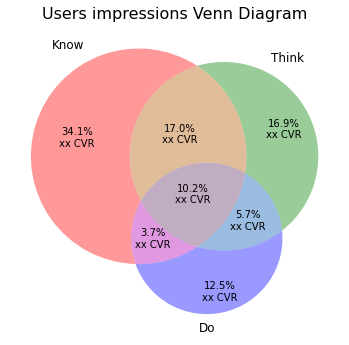

In [88]:
#help: subsets = (Abc, 
#                 aBc, 
#                 ABc, 
#                 abC, 
#                 AbC, 
#                 aBC, 
#                 ABC)
# A = know, B=think, C=do

plt.figure(figsize=(6,6))
v = venn3(subsets = (user_overlap_perc.users_exlusive_know[0], 
                 user_overlap_perc.users_exlusive_think[0], 
                 user_overlap_perc.users_know_think[0], 
                 user_overlap_perc.users_exlusive_do[0], 
                 user_overlap_perc.users_know_do[0], 
                 user_overlap_perc.users_think_do[0], 
                 user_overlap_perc.users_know_think_do[0]), set_labels = ('Know', 'Think', 'Do'))

plt.title("Users impressions Venn Diagram", fontsize=16)

# setting color of id 11 to purple
#v.get_patch_by_id('11').set_color('purple')
#setting label of id 10 to New Text
v.get_label_by_id('100').set_text(str(user_overlap_perc.users_exlusive_know[0])  + '%\n' 'xx CVR' )
v.get_label_by_id('010').set_text(str(user_overlap_perc.users_exlusive_think[0]) + '%\n' 'xx CVR' )
v.get_label_by_id('110').set_text(str(user_overlap_perc.users_know_think[0])     + '%\n' 'xx CVR' )
v.get_label_by_id('001').set_text(str(user_overlap_perc.users_exlusive_do[0])    + '%\n' 'xx CVR' )
v.get_label_by_id('101').set_text(str(user_overlap_perc.users_know_do[0])        + '%\n' 'xx CVR' )
v.get_label_by_id('011').set_text(str(user_overlap_perc.users_think_do[0])       + '%\n' 'xx CVR' )
v.get_label_by_id('111').set_text(str(user_overlap_perc.users_know_think_do[0])  + '%\n' 'xx CVR' )

plt.show()

### Conversion Venn Diagram !!! THIS PART IS WRONG!! CORRECT QUERY!!!

In [89]:
query = '''
SELECT * 
FROM `rb-hygiene-markets-global-prod.adh_results_apac.rc_conversion_user_overlap_dv360youtube_1_20210712_20210822_1`
'''
conv_user_overlap = client.query(query)
conv_user_overlap= conv_user_overlap.to_dataframe()
conv_user_overlap.to_csv('conv_user_overlap.csv', index=False)

#conv_user_overlap = pd.read_csv("conv_user_overlap.csv")
conv_user_overlap

partner_id  advertiser_id  campaign_id  conv_users_exlusive_know  \
0   599149418      603701472      6822204                         0   

   conv_users_exlusive_think  conv_users_exlusive_do  conv_users_know_think  \
0                          6                     251                      0   

   conv_users_know_do  conv_users_think_do  conv_users_know_think_do  \
0                   0                    0                         0   

   total_conversions  total_conversions2  reach_total_users  \
0                364                 364                257   

   total_conv_users_summing  
0                       257

In [90]:
conv_user_overlap/user_overlap.values*100

partner_id  advertiser_id  campaign_id  conv_users_exlusive_know  \
0       100.0          100.0        100.0                       0.0   

   conv_users_exlusive_think  conv_users_exlusive_do  conv_users_know_think  \
0                   0.000473                0.026626                    0.0   

   conv_users_know_do  conv_users_think_do  conv_users_know_think_do  \
0                 0.0                  0.0                       0.0   

   total_conversions  total_conversions2  reach_total_users  \
0           0.001351            0.001351           0.003414   

   total_conv_users_summing  
0                  0.003414

In [91]:
cvr_df = pd.DataFrame()
cvr_df['cvr_know'] = round(conv_user_overlap.conv_users_exlusive_know/user_overlap.users_exlusive_know.values*100, 3)
cvr_df['cvr_think'] = round(conv_user_overlap.conv_users_exlusive_think/user_overlap.users_exlusive_think.values*100, 3)
cvr_df['cvr_do'] = round(conv_user_overlap.conv_users_exlusive_do/user_overlap.users_exlusive_do.values*100, 3)
cvr_df['cvr_know_think'] = round(conv_user_overlap.conv_users_know_think/user_overlap.users_know_think.values*100, 3)
cvr_df['cvr_know_do'] = round(conv_user_overlap.conv_users_know_do/user_overlap.users_know_do.values*100, 3)
cvr_df['cvr_think_do'] = round(conv_user_overlap.conv_users_think_do/user_overlap.users_think_do.values*100, 3)
cvr_df['cvr_know_think_do'] = round(conv_user_overlap.conv_users_know_think_do/user_overlap.users_know_think_do.values*100, 3)
cvr_df['overall'] = round(conv_user_overlap.total_conversions/user_overlap.total_impressions.values*100, 3)
cvr_df

cvr_know  cvr_think  cvr_do  cvr_know_think  cvr_know_do  cvr_think_do  \
0       0.0        0.0   0.027             0.0          0.0           0.0   

   cvr_know_think_do  overall  
0                0.0    0.001

##### Estimate user impressions percentage

In [92]:
user_overlap_perc = user_overlap[['users_exlusive_know', 'users_exlusive_think', 'users_exlusive_do', 'users_know_think', 'users_know_do', 'users_think_do', 'users_know_think_do', 'reach_total_users']]
user_overlap_perc = round(user_overlap_perc/ user_overlap_perc.reach_total_users[0]*100, 1)
user_overlap_perc

users_exlusive_know  users_exlusive_think  users_exlusive_do  \
0                 34.1                  16.9               12.5   

   users_know_think  users_know_do  users_think_do  users_know_think_do  \
0              17.0            3.7             5.7                 10.2   

   reach_total_users  
0              100.0

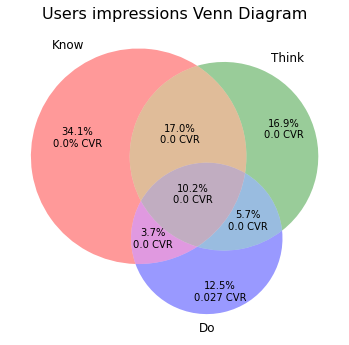

In [93]:
#help: subsets = (Abc, 
#                 aBc, 
#                 ABc, 
#                 abC, 
#                 AbC, 
#                 aBC, 
#                 ABC)
# A = know, B=think, C=do

plt.figure(figsize=(6,6))
v = venn3(subsets = (user_overlap_perc.users_exlusive_know[0], 
                 user_overlap_perc.users_exlusive_think[0], 
                 user_overlap_perc.users_know_think[0], 
                 user_overlap_perc.users_exlusive_do[0], 
                 user_overlap_perc.users_know_do[0], 
                 user_overlap_perc.users_think_do[0], 
                 user_overlap_perc.users_know_think_do[0]), set_labels = ('Know', 'Think', 'Do'))

plt.title("Users impressions Venn Diagram", fontsize=16)

# setting color of id 11 to purple
#v.get_patch_by_id('11').set_color('purple')
#setting label of id 10 to New Text
v.get_label_by_id('100').set_text(str(user_overlap_perc.users_exlusive_know[0])  + '%\n' + str(cvr_df.cvr_know[0]) + '% CVR' )
v.get_label_by_id('010').set_text(str(user_overlap_perc.users_exlusive_think[0]) + '%\n' + str(cvr_df.cvr_think[0]) + ' CVR' )
v.get_label_by_id('110').set_text(str(user_overlap_perc.users_know_think[0])     + '%\n' + str(cvr_df.cvr_know_think[0]) + ' CVR' )
v.get_label_by_id('001').set_text(str(user_overlap_perc.users_exlusive_do[0])    + '%\n' + str(cvr_df.cvr_do[0]) + ' CVR' )
v.get_label_by_id('101').set_text(str(user_overlap_perc.users_know_do[0])        + '%\n' + str(cvr_df.cvr_know_do[0]) + ' CVR' )
v.get_label_by_id('011').set_text(str(user_overlap_perc.users_think_do[0])       + '%\n' + str(cvr_df.cvr_think_do[0]) + ' CVR' )
v.get_label_by_id('111').set_text(str(user_overlap_perc.users_know_think_do[0])  + '%\n' + str(cvr_df.cvr_know_think_do[0]) + ' CVR' )

plt.show()

In [94]:
cvr_df.cvr_know[0]

0.0